**SPORTS ANALYTICS PROJECT**

**Group Number:** 22

**Team Members:**

Merlin Beaufils - mb4988

Karpagam Murugappan - km3702

Tempe Gu - yg2831

Sitong Qian - sq2239

**SOCCER MATCH OUTCOME PREDICTION AND MAKING BETS RESULTING IN MAXIMUM PROFIT**

Target variable - home_win = 0 | 1

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV

In [2]:
data=pd.read_csv('joined.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8648 entries, 0 to 8647
Data columns (total 71 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home                            8648 non-null   object 
 1   Away                            8648 non-null   object 
 2   1_PROB                          8648 non-null   float64
 3   home_win                        8648 non-null   int64  
 4   season                          8648 non-null   int64  
 5   home_cumulative_season_win      8411 non-null   float64
 6   away_cumulative_season_win      8412 non-null   float64
 7   diff_cumulative_season_win      8400 non-null   float64
 8   home_cumulative_win             8584 non-null   float64
 9   away_cumulative_win             8577 non-null   float64
 10  diff_cumulative_win             8562 non-null   float64
 11  home_cumulative_season_xG_diff  8411 non-null   float64
 12  away_cumulative_season_xG_diff  84

In [3]:
data.tail(5)

Home         Away    1_PROB  home_win  season  \
8643  Real Sociedad  Atl. Madrid  0.367647         0       5   
8644        Granada     Espanyol  0.694190         0       5   
8645         Alaves        Cadiz  0.208333         0       5   
8646          Elche       Getafe  0.314465         1       5   
8647        Venezia     Cagliari  0.187266         0       5   

      home_cumulative_season_win  away_cumulative_season_win  \
8643                    0.459459                    0.540541   
8644                    0.216216                    0.270270   
8645                    0.216216                    0.189189   
8646                    0.270270                    0.216216   
8647                    0.162162                    0.162162   

      diff_cumulative_season_win  home_cumulative_win  away_cumulative_win  \
8643                   -0.081081             0.407407             0.576720   
8644                   -0.054054             0.327434             0.271523   
8645                    0.027027             0.291005             0.240000   
8646                    0.054054             0.240000             0.322751   
8647                    0.000000             0.162162             0.248677   

      ...  diff_last8_xG_diff_exp_0.15  home_last8_xG_diff_exp_0.25  \
8643  ...                     0.105230                     0.793640   
8644  ...                     0.249625                    -0.407472   
8645  ...                    -1.194854                    -0.711168   
8646  ...                    -1.145432                    -1.200147   
8647  ...                    -0.596799                    -1.551987   

      away_last8_xG_diff_exp_0.25  diff_last8_xG_diff_exp_0.25  \
8643                     0.691636                     0.102004   
8644                    -0.676643                     0.269171   
8645                     0.472983                    -1.184151   
8646                    -0.039406                    -1.160741   
8647                    -0.944527                    -0.607460   

      home_last12_xG_diff_exp_0.15  away_last12_xG_diff_exp_0.15  \
8643                      0.702126                      0.471596   
8644                     -0.339322                     -0.845032   
8645                     -0.670750                      0.559033   
8646                     -1.185407                     -0.074998   
8647                     -1.374143                     -0.818189   

      diff_last12_xG_diff_exp_0.15  home_last12_xG_diff_exp_0.25  \
8643                      0.230530                      0.709304   
8644                      0.505710                     -0.337097   
8645                     -1.229783                     -0.667331   
8646                     -1.110409                     -1.187933   
8647                     -0.555954                     -1.384921   

      away_last12_xG_diff_exp_0.25  diff_last12_xG_diff_exp_0.25  
8643                      0.486091                      0.223214  
8644                     -0.827770                      0.490673  
8645                      0.559240                     -1.226571  
8646                     -0.074210                     -1.113723  
8647                     -0.829556                     -0.555366  

[5 rows x 71 columns]

**Handling missing values**

In [4]:
data.isna().sum()

Home                               0
Away                               0
1_PROB                             0
home_win                           0
season                             0
                                ... 
away_last12_xG_diff_exp_0.15     812
diff_last12_xG_diff_exp_0.15    1017
home_last12_xG_diff_exp_0.25     808
away_last12_xG_diff_exp_0.25     812
diff_last12_xG_diff_exp_0.25    1017
Length: 71, dtype: int64

In [5]:
max(data.isna().sum())

1017



1.   There is a maximum of 1017 rows with missing values; this is because we try to take the average of previous 12 (maximum) games and we do not have history of 12 games for the initial matches.
2.   Dropping all rows with NaN



In [6]:
data = data.dropna()

In [7]:
data = data.drop(columns=['Home','Away'])

In [8]:
data.shape

(7473, 69)

**Class Balance**

In [9]:
print(f'Total observations in dataset : {data.home_win.value_counts().sum()}')
print(f'# home_win = 1 in dataset : {data.home_win.value_counts()[1]}')
print(f'# homw_win = 0 in dataset : {data.home_win.value_counts()[0]}')

Total observations in dataset : 7473
# home_win = 1 in dataset : 3232
# homw_win = 0 in dataset : 4241


* Dataset is roughly balanced !!!

**Train - validation - test split**

* season in data corresponds to each successive year
    * 2017 to 2018 - season 1
    * 2018 to 2019 - season 2
    * 2019 to 2020 - season 3
    * 2020 to 2021 - season 4
    * 2021 to 2022 - season 5
* This is a time series data - STRUCTURED SPLITTING !!!
* Season 1 to 3 will be training set; Season 4 will be validation set and Season 5 will be test set

In [10]:
train = data.loc[data.season<=3]
val = data.loc[data.season==4]
test = data.loc[data.season==5]

#Removing target column
tmp = list(data.columns)
tmp.remove('home_win')

train_X = train[tmp]
train_y = train['home_win']

val_X = val[tmp]
val_y = val['home_win']

test_X = test[tmp]
test_y = test['home_win']

In [11]:
print(f'Total observations in training dataset : {train_y.value_counts().sum()}')
print(f'# home_win = 1 in training dataset : {train_y.value_counts()[1]}')
print(f'# homw_win = 0 in training dataset : {train_y.value_counts()[0]}')

Total observations in training dataset : 4066
# home_win = 1 in training dataset : 1817
# homw_win = 0 in training dataset : 2249


In [12]:
print(f'Total observations in validation dataset : {val_y.value_counts().sum()}')
print(f'# home_win = 1 in validation dataset : {val_y.value_counts()[1]}')
print(f'# homw_win = 0 in validation dataset : {val_y.value_counts()[0]}')

Total observations in validation dataset : 1704
# home_win = 1 in validation dataset : 686
# homw_win = 0 in validation dataset : 1018


In [13]:
print(f'Total observations in testing dataset : {test_y.value_counts().sum()}')
print(f'# home_win = 1 in testing dataset : {test_y.value_counts()[1]}')
print(f'# homw_win = 0 in testing dataset : {test_y.value_counts()[0]}')

Total observations in testing dataset : 1703
# home_win = 1 in testing dataset : 729
# homw_win = 0 in testing dataset : 974


**Development set**

In [14]:
dev_X = pd.concat([train_X,val_X])
dev_y = pd.concat([train_y,val_y])

**Pipelines, Parameters & Models Dictionary**

In [15]:
pipes = {}

pipes['LogisticRegression'] = Pipeline([
    ('scaler',StandardScaler()),
    ('logr',LogisticRegression(max_iter=5000))
])
pipes['LogisticRegressionWithPCA'] = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA()),
    ('logr',LogisticRegression(max_iter=5000))
])
pipes['RandomForestClassifier'] = Pipeline([
    ('scaler',StandardScaler()),
    ('rfc',RandomForestClassifier())
])
pipes['RandomForestClassifierWithPCA'] = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA()),
    ('rfc',RandomForestClassifier())
])
pipes['AdaBoostClassifier'] = Pipeline([
    ('scaler',StandardScaler()),
    ('ada',AdaBoostClassifier())
])
pipes['AdaBoostClassifierWithPCA'] = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA()),
    ('ada',AdaBoostClassifier())
])
pipes['GradientBoostingClassifier'] = Pipeline([
    ('scaler',StandardScaler()),
    ('gbc',GradientBoostingClassifier())
])
pipes['GradientBoostingClassifierWithPCA'] = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA()),
    ('gbc',GradientBoostingClassifier())
])
pipes['DecisionTreeClassifier'] = Pipeline([
    ('dtc',DecisionTreeClassifier())
])
pipes['DecisionTreeClassifierWithPCA'] = Pipeline([
    ('pca',PCA()),
    ('dtc',DecisionTreeClassifier())
])
pipes['SVC'] = Pipeline([
    ('scaler',StandardScaler()),
    ('svc',SVC())
])
pipes['SVCWithPCA'] = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA()),
    ('svc',SVC())
])

In [16]:
params = {}

params['LogisticRegression'] = {'logr__penalty' : ['l2'],
                                'logr__C' :[0.01,1,10,100]}
params['LogisticRegressionWithPCA'] = {'logr__penalty' : ['l2'],
                                       'logr__C' :[0.01,1,10,100],
                                       'pca__n_components': [3,4,5]}

params['RandomForestClassifier'] = {'rfc__n_estimators': [100,200,300],
                                    'rfc__max_depth': [5,6,7,8,9,10]}
params['RandomForestClassifierWithPCA'] = {'rfc__n_estimators': [100,200,300],
                                           'rfc__max_depth': [5,6,7,8,9,10],
                                           'pca__n_components': [3,4,5]}

params['AdaBoostClassifier'] = {'ada__n_estimators': [100,200,300],
                                'ada__learning_rate': [0.1,0.001,0.05]}
params['AdaBoostClassifierWithPCA'] = {'ada__n_estimators': [100,200,300],
                                       'ada__learning_rate': [0.1,0.001,0.05],
                                       'pca__n_components': [3,4,5]}

params['GradientBoostingClassifier'] = {'gbc__loss':[ 'deviance', 'exponential'],
                                        'gbc__n_estimators': [100,200,300],
                                        'gbc__learning_rate': [0.1,0.01,0.05]}
params['GradientBoostingClassifierWithPCA'] = {'gbc__loss':[ 'deviance', 'exponential'],
                                               'gbc__n_estimators': [100,200,300],
                                               'gbc__learning_rate': [0.1,0.01,0.05],
                                               'pca__n_components': [3,4,5]}

params['DecisionTreeClassifier'] = {'dtc__max_depth': [5,6,7,8,9,10]}  
params['DecisionTreeClassifierWithPCA'] = {'dtc__max_depth': [5,6,7,8,9,10],
                                           'pca__n_components': [3,4,5]}  

params['SVC'] = {'svc__C': np.logspace(-3,3,5),
                 'svc__gamma': np.logspace(1,5,5)}        
params['SVCWithPCA'] = {'svc__C': np.logspace(-3,3,5),
                        'svc__gamma': np.logspace(1,5,5),
                        'pca__n_components': [3,4,5]}          


In [17]:
results = {}
results['ModelName'] = []
results['BestParam'] = []
results['BestScore'] = []
results['TestAccuracy'] = []
results['TestPrecision'] = []
results['TestRecall'] = []
results['TestF1'] = []

In [18]:

models = {}
for k in pipes.keys():
  models[k] = GridSearchCV(pipes[k],params[k], cv=2).fit(dev_X,dev_y)
  results['ModelName'].append(k)
  results['BestParam'].append(models[k].best_params_)
  results['BestScore'].append(models[k].best_score_)
  results['TestAccuracy'].append(accuracy_score(test_y, models[k].predict(test_X)))
  results['TestPrecision'].append(precision_score(test_y, models[k].predict(test_X)))
  results['TestRecall'].append(recall_score(test_y, models[k].predict(test_X)))
  results['TestF1'].append(f1_score(test_y, models[k].predict(test_X)))
  joblib.dump(models[k],k+'.pkl')
  print(k, 'DONE')
  

LogisticRegression DONE
LogisticRegressionWithPCA DONE
RandomForestClassifier DONE
RandomForestClassifierWithPCA DONE
AdaBoostClassifier DONE
AdaBoostClassifierWithPCA DONE
GradientBoostingClassifier DONE
GradientBoostingClassifierWithPCA DONE
DecisionTreeClassifier DONE
DecisionTreeClassifierWithPCA DONE


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC DONE


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVCWithPCA DONE


**Feature importance**

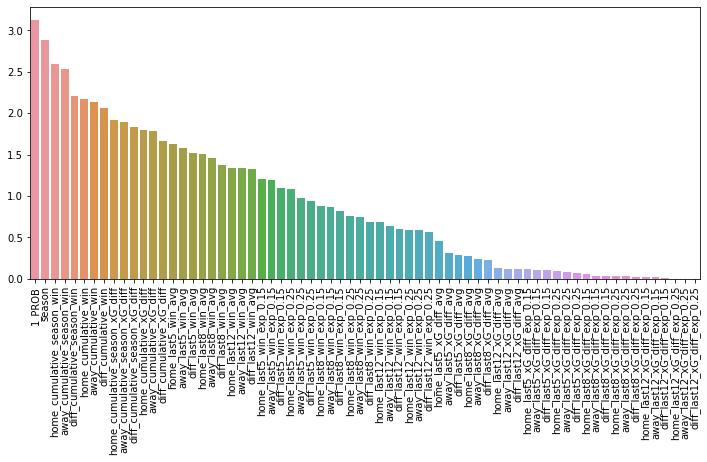

In [19]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
dict_d={}
for i in range(len(tmp)):
   dict_d[tmp[i]] = abs(models['LogisticRegression'].best_estimator_['logr'].coef_[:,i][0])
dict1 = dict(sorted(dict_d.items(), key=lambda item: item[1],reverse=True))
sns.barplot(x=list(dict1.keys()),y=list(dict1.values()),ax=ax);
ax.set_xticklabels(tmp,rotation=90);

MODEL RandomForestClassifier


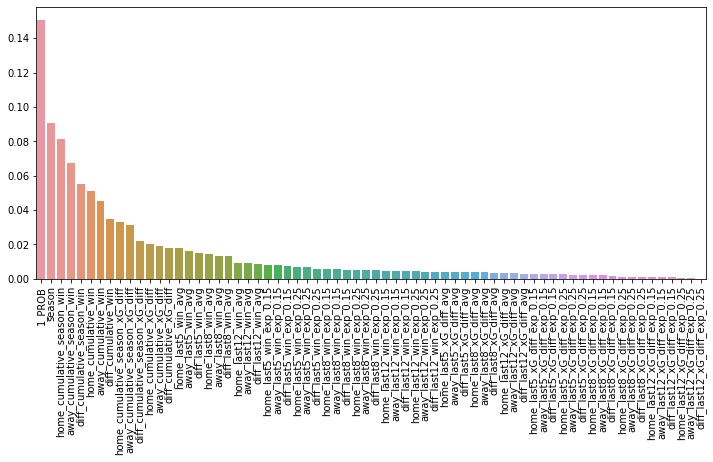

---------------------------------------------------------------------------------------------------------
MODEL AdaBoostClassifier


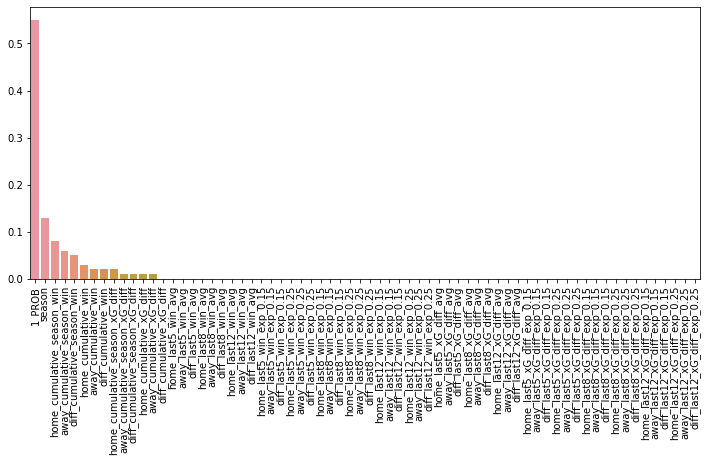

---------------------------------------------------------------------------------------------------------
MODEL GradientBoostingClassifier


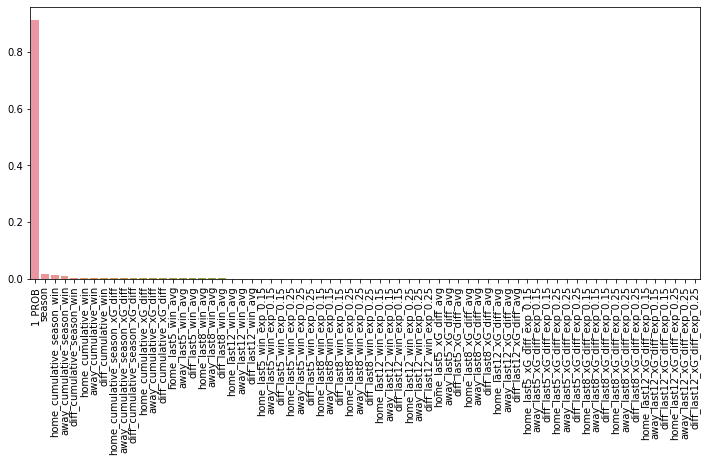

---------------------------------------------------------------------------------------------------------
MODEL DecisionTreeClassifier


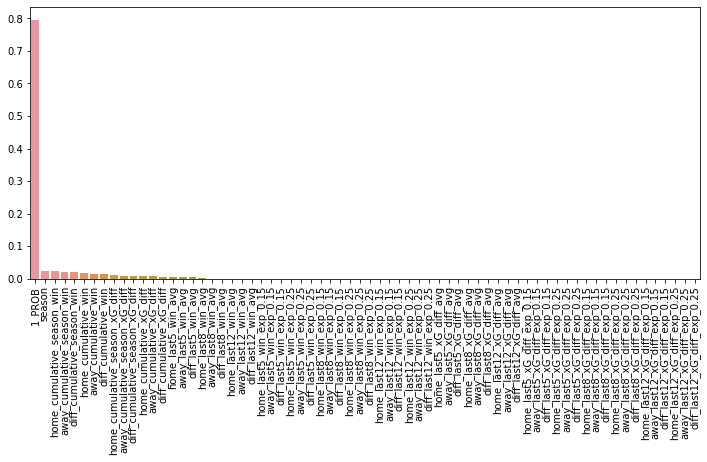

---------------------------------------------------------------------------------------------------------


In [20]:
for k in models.keys():
  if 'LogisticRegression' not in k and 'SVC' not in k and 'PCA' not in k:
    print('MODEL '+k)
    fig,ax = plt.subplots(1,1,figsize=(12,5))
    dict_d={}
    for i in range(len(tmp)):
      dict_d[tmp[i]] = abs(models[k].best_estimator_[models[k].best_estimator_.steps[-1][0]].feature_importances_[i])
    dict1 = dict(sorted(dict_d.items(), key=lambda item: item[1],reverse=True))
    sns.barplot(x=list(dict1.keys()),y=list(dict1.values()),ax=ax);
    ax.set_xticklabels(tmp,rotation=90);
    plt.show();
    print('---------------------------------------------------------------------------------------------------------')



*   One noticeable point here is that across the models trained so far, **1_PROB, season, home_cumulative_season_win, away_cumulative_season_win, diff_cumulative_season_win** seems to be the top 5 features.


**Training models with only the top 5 features stated above**

In [21]:
top_5_features = ['1_PROB', 'season', 'home_cumulative_season_win', 'away_cumulative_season_win', 'diff_cumulative_season_win']

In [22]:
for k in pipes.keys():
  models[k + ' Top 5 features'] = GridSearchCV(pipes[k],params[k], cv=2).fit(dev_X[top_5_features],dev_y)
  results['ModelName'].append(k + ' Top 5 features')
  results['BestParam'].append(models[k + ' Top 5 features'].best_params_)
  results['BestScore'].append(models[k + ' Top 5 features'].best_score_)
  results['TestAccuracy'].append(accuracy_score(test_y, models[k + ' Top 5 features'].predict(test_X[top_5_features])))
  results['TestPrecision'].append(precision_score(test_y, models[k + ' Top 5 features'].predict(test_X[top_5_features])))
  results['TestRecall'].append(recall_score(test_y, models[k + ' Top 5 features'].predict(test_X[top_5_features])))
  results['TestF1'].append(f1_score(test_y, models[k + ' Top 5 features'].predict(test_X[top_5_features])))
  joblib.dump(models[k+' Top 5 features'], k+' Top 5 features'+'.pkl')
  print(k + ' Top 5 features', 'DONE')

LogisticRegression Top 5 features DONE
LogisticRegressionWithPCA Top 5 features DONE
RandomForestClassifier Top 5 features DONE
RandomForestClassifierWithPCA Top 5 features DONE
AdaBoostClassifier Top 5 features DONE
AdaBoostClassifierWithPCA Top 5 features DONE
GradientBoostingClassifier Top 5 features DONE
GradientBoostingClassifierWithPCA Top 5 features DONE
DecisionTreeClassifier Top 5 features DONE
DecisionTreeClassifierWithPCA Top 5 features DONE


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC Top 5 features DONE


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVCWithPCA Top 5 features DONE


**Neural Network Models**

In [23]:
train_y_nn = to_categorical(train_y,2)
val_y_nn = to_categorical(val_y,2)
test_y_nn = to_categorical(test_y,2)
dev_y_nn = to_categorical(dev_y,2)

In [24]:
history={}

In [25]:
models['NN_1'] = Sequential() 
models['NN_1'].add(Dense(len(tmp), activation='relu', input_dim=len(tmp)))
models['NN_1'].add(Dense(2*len(tmp), activation='relu'))
models['NN_1'].add(Dense(len(tmp), activation='relu'))
models['NN_1'].add(Dense(2, activation='linear')) 
models['NN_1'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_1'].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 68)                4692      
                                                                 
 dense_1 (Dense)             (None, 136)               9384      
                                                                 
 dense_2 (Dense)             (None, 68)                9316      
                                                                 
 dense_3 (Dense)             (None, 2)                 138       
                                                                 
Total params: 23,530
Trainable params: 23,530
Non-trainable params: 0
_________________________________________________________________


In [26]:
models['NN_2'] = Sequential() 
models['NN_2'].add(Dense(128, activation='relu', input_dim=len(tmp)))
models['NN_2'].add(Dense(64, activation='relu'))
models['NN_2'].add(Dense(32, activation='relu'))
models['NN_2'].add(Dense(2, activation='linear')) 
models['NN_2'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_2'].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               8832      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 19,234
Trainable params: 19,234
Non-trainable params: 0
_________________________________________________________________


In [27]:
models['NN_3'] = Sequential() 
models['NN_3'].add(Dense(len(tmp), activation='relu', input_dim=len(tmp)))
models['NN_3'].add(Dropout(0.3))
models['NN_3'].add(Dense(2*len(tmp), activation='relu'))
models['NN_3'].add(Dropout(0.3))
models['NN_3'].add(Dense(len(tmp), activation='relu'))
models['NN_3'].add(Dropout(0.3))
models['NN_3'].add(Dense(2, activation='linear')) 
models['NN_3'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_3'].summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 68)                4692      
                                                                 
 dropout (Dropout)           (None, 68)                0         
                                                                 
 dense_9 (Dense)             (None, 136)               9384      
                                                                 
 dropout_1 (Dropout)         (None, 136)               0         
                                                                 
 dense_10 (Dense)            (None, 68)                9316      
                                                                 
 dropout_2 (Dropout)         (None, 68)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                

In [28]:
for k in models.keys():
  if 'NN_' in k:
    history[k] = models[k].fit(train_X, train_y_nn, epochs=50, validation_data=(val_X, val_y_nn))
    print(k, ' DONE')

Epoch 1/50
128/128 [==============================] - 2s 5ms/step - loss: 0.9417 - accuracy: 0.6156 - val_loss: 0.6684 - val_accuracy: 0.6673
Epoch 2/50
128/128 [==============================] - 0s 4ms/step - loss: 0.7212 - accuracy: 0.6058 - val_loss: 0.7631 - val_accuracy: 0.6626
Epoch 3/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6402 - val_loss: 0.6374 - val_accuracy: 0.6790
Epoch 4/50
128/128 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6535 - val_loss: 0.6313 - val_accuracy: 0.6808
Epoch 5/50
128/128 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6473 - val_loss: 0.6351 - val_accuracy: 0.6772
Epoch 6/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6581 - val_loss: 0.6158 - val_accuracy: 0.6749
Epoch 7/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6557 - val_loss: 0.6128 - val_accuracy: 0.6813
Epoch 

MODEL NN_1


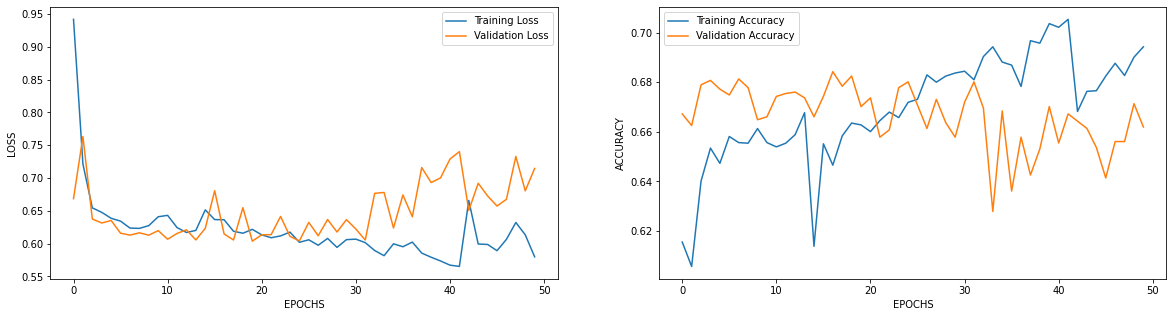

-------------------------------------------------------------------------------------------------------------------------
MODEL NN_2


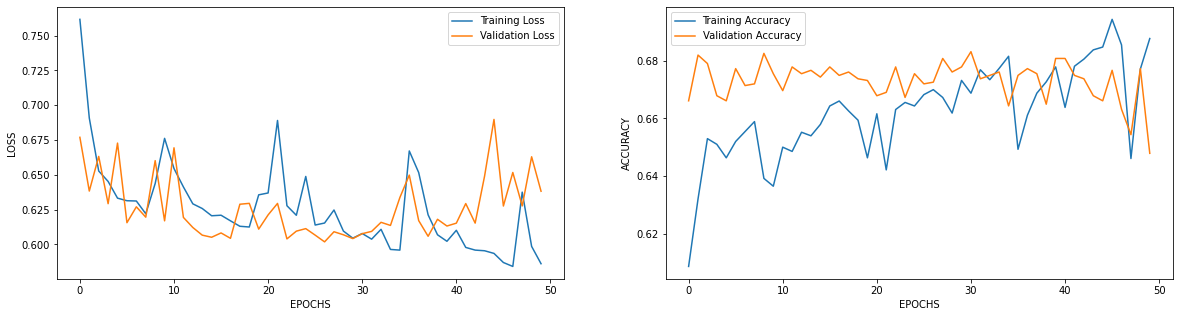

-------------------------------------------------------------------------------------------------------------------------
MODEL NN_3


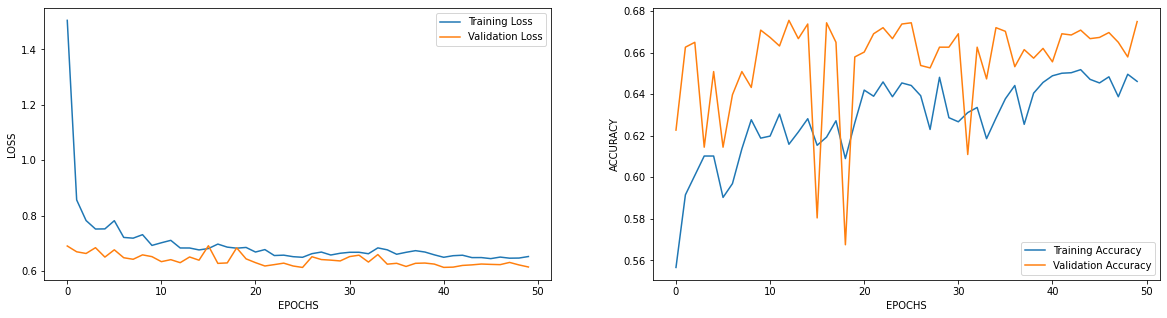

-------------------------------------------------------------------------------------------------------------------------


In [29]:
for k in models.keys():
  if 'NN_' in k:
    print('MODEL '+k)
    hist_df = pd.DataFrame(history[k].history)
    fig,ax = plt.subplots(1,2,figsize=(20,5));
    ax[0].plot(hist_df.index,hist_df.loss,label='Training Loss');
    ax[0].plot(hist_df.index,hist_df.val_loss,label='Validation Loss');
    ax[0].set_xlabel('EPOCHS');
    ax[0].set_ylabel('LOSS');
    ax[0].legend();
    ax[1].plot(hist_df.index,hist_df.accuracy,label='Training Accuracy');
    ax[1].plot(hist_df.index,hist_df.val_accuracy,label='Validation Accuracy');
    ax[1].set_xlabel('EPOCHS');
    ax[1].set_ylabel('ACCURACY');
    ax[1].legend();
    plt.show();
    print('-------------------------------------------------------------------------------------------------------------------------')


In [30]:
for k in models.keys():
  if 'NN_' in k:
    results['ModelName'].append(k)
    results['BestParam'].append('model structure')
    results['BestScore'].append(history[k].history['val_accuracy'][-1])
    results['TestAccuracy'].append(accuracy_score(test_y, np.argmax(models[k].predict(test_X),axis=1)))
    results['TestPrecision'].append(precision_score(test_y, np.argmax(models[k].predict(test_X),axis=1)))
    results['TestRecall'].append(recall_score(test_y, np.argmax(models[k].predict(test_X),axis=1)))
    results['TestF1'].append(f1_score(test_y, np.argmax(models[k].predict(test_X),axis=1)))


54/54 [==============================] - 0s 1ms/step


**Repeating the above models using only cumulative features**

In [31]:
cum_features = ['1_PROB','season'] + [c for c in tmp if 'cumulative' in c]
cum_features

['1_PROB',
 'season',
 'home_cumulative_season_win',
 'away_cumulative_season_win',
 'diff_cumulative_season_win',
 'home_cumulative_win',
 'away_cumulative_win',
 'diff_cumulative_win',
 'home_cumulative_season_xG_diff',
 'away_cumulative_season_xG_diff',
 'diff_cumulative_season_xG_diff',
 'home_cumulative_xG_diff',
 'away_cumulative_xG_diff',
 'diff_cumulative_xG_diff']

In [32]:
for k in pipes.keys():
  models[k+' cumulative features'] = GridSearchCV(pipes[k],params[k], cv=2).fit(train_X[cum_features],train_y)
  results['ModelName'].append(k+' cumulative features')
  results['BestParam'].append(models[k+' cumulative features'].best_params_)
  results['BestScore'].append(models[k+' cumulative features'].best_score_)
  results['TestAccuracy'].append(accuracy_score(test_y, models[k+' cumulative features'].predict(test_X[cum_features])))
  results['TestPrecision'].append(precision_score(test_y, models[k+' cumulative features'].predict(test_X[cum_features])))
  results['TestRecall'].append(recall_score(test_y, models[k+' cumulative features'].predict(test_X[cum_features])))
  results['TestF1'].append(f1_score(test_y, models[k+' cumulative features'].predict(test_X[cum_features])))
  joblib.dump(models[k+' cumulative features'], k+' cumulative features'+'.pkl')
  print(k+' cumulative features', 'DONE')
  

LogisticRegression cumulative features DONE
LogisticRegressionWithPCA cumulative features DONE
RandomForestClassifier cumulative features DONE
RandomForestClassifierWithPCA cumulative features DONE
AdaBoostClassifier cumulative features DONE
AdaBoostClassifierWithPCA cumulative features DONE
GradientBoostingClassifier cumulative features DONE
GradientBoostingClassifierWithPCA cumulative features DONE
DecisionTreeClassifier cumulative features DONE
DecisionTreeClassifierWithPCA cumulative features DONE


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC cumulative features DONE


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVCWithPCA cumulative features DONE


In [33]:
models['NN_1 cumulative features'] = Sequential() 
models['NN_1 cumulative features'].add(Dense(len(cum_features), activation='relu', input_dim=len(cum_features)))
models['NN_1 cumulative features'].add(Dense(2*len(cum_features), activation='relu'))
models['NN_1 cumulative features'].add(Dense(len(cum_features), activation='relu'))
models['NN_1 cumulative features'].add(Dense(2, activation='linear')) 
models['NN_1 cumulative features'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_1 cumulative features'].summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 14)                210       
                                                                 
 dense_13 (Dense)            (None, 28)                420       
                                                                 
 dense_14 (Dense)            (None, 14)                406       
                                                                 
 dense_15 (Dense)            (None, 2)                 30        
                                                                 
Total params: 1,066
Trainable params: 1,066
Non-trainable params: 0
_________________________________________________________________


In [34]:
models['NN_2 cumulative features'] = Sequential() 
models['NN_2 cumulative features'].add(Dense(128, activation='relu', input_dim=len(cum_features)))
models['NN_2 cumulative features'].add(Dense(64, activation='relu'))
models['NN_2 cumulative features'].add(Dense(32, activation='relu'))
models['NN_2 cumulative features'].add(Dense(2, activation='linear')) 
models['NN_2 cumulative features'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_2 cumulative features'].summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               1920      
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 2)                 66        
                                                                 
Total params: 12,322
Trainable params: 12,322
Non-trainable params: 0
_________________________________________________________________


In [35]:
models['NN_3 cumulative features'] = Sequential() 
models['NN_3 cumulative features'].add(Dense(len(cum_features), activation='relu', input_dim=len(cum_features)))
models['NN_3 cumulative features'].add(Dropout(0.3))
models['NN_3 cumulative features'].add(Dense(2*len(cum_features), activation='relu'))
models['NN_3 cumulative features'].add(Dropout(0.3))
models['NN_3 cumulative features'].add(Dense(len(cum_features), activation='relu'))
models['NN_3 cumulative features'].add(Dropout(0.3))
models['NN_3 cumulative features'].add(Dense(2, activation='linear')) 
models['NN_3 cumulative features'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_3 cumulative features'].summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 14)                210       
                                                                 
 dropout_3 (Dropout)         (None, 14)                0         
                                                                 
 dense_21 (Dense)            (None, 28)                420       
                                                                 
 dropout_4 (Dropout)         (None, 28)                0         
                                                                 
 dense_22 (Dense)            (None, 14)                406       
                                                                 
 dropout_5 (Dropout)         (None, 14)                0         
                                                                 
 dense_23 (Dense)            (None, 2)                

In [36]:
for k in models.keys():
  if 'NN_' in k and 'cumulative features' in k:
    history[k] = models[k].fit(train_X[cum_features], train_y_nn, epochs=50, validation_data=(val_X[cum_features], val_y_nn))
    print(k, ' DONE')

Epoch 1/50
128/128 [==============================] - 1s 4ms/step - loss: 3.4453 - accuracy: 0.4695 - val_loss: 0.8076 - val_accuracy: 0.3609
Epoch 2/50
128/128 [==============================] - 0s 2ms/step - loss: 0.7842 - accuracy: 0.4120 - val_loss: 0.7876 - val_accuracy: 0.4173
Epoch 3/50
128/128 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.5275 - val_loss: 0.7230 - val_accuracy: 0.6191
Epoch 4/50
128/128 [==============================] - 0s 2ms/step - loss: 0.6753 - accuracy: 0.6215 - val_loss: 0.7166 - val_accuracy: 0.6667
Epoch 5/50
128/128 [==============================] - 0s 2ms/step - loss: 0.6605 - accuracy: 0.6468 - val_loss: 0.6731 - val_accuracy: 0.6743
Epoch 6/50
128/128 [==============================] - 0s 2ms/step - loss: 0.6469 - accuracy: 0.6535 - val_loss: 0.6621 - val_accuracy: 0.6784
Epoch 7/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6488 - val_loss: 0.6500 - val_accuracy: 0.6725
Epoch 

MODEL NN_1 cumulative features


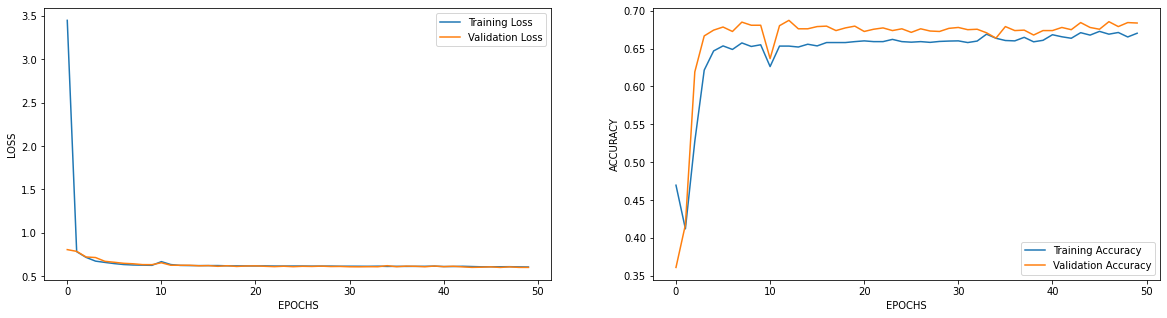

-------------------------------------------------------------------------------------------------------------------------
MODEL NN_2 cumulative features


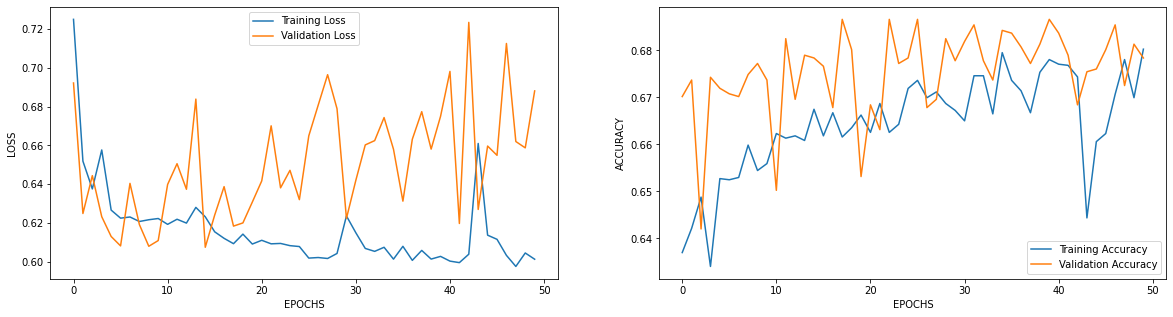

-------------------------------------------------------------------------------------------------------------------------
MODEL NN_3 cumulative features


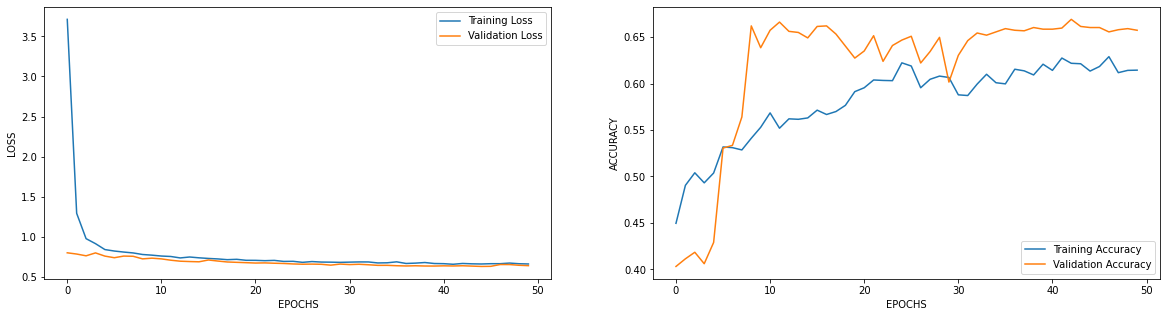

-------------------------------------------------------------------------------------------------------------------------


In [37]:
for k in models.keys():
  if 'NN_' in k and 'cumulative features' in k:
    print('MODEL '+k)
    hist_df = pd.DataFrame(history[k].history)
    fig,ax = plt.subplots(1,2,figsize=(20,5));
    ax[0].plot(hist_df.index,hist_df.loss,label='Training Loss');
    ax[0].plot(hist_df.index,hist_df.val_loss,label='Validation Loss');
    ax[0].set_xlabel('EPOCHS');
    ax[0].set_ylabel('LOSS');
    ax[0].legend();
    ax[1].plot(hist_df.index,hist_df.accuracy,label='Training Accuracy');
    ax[1].plot(hist_df.index,hist_df.val_accuracy,label='Validation Accuracy');
    ax[1].set_xlabel('EPOCHS');
    ax[1].set_ylabel('ACCURACY');
    ax[1].legend();
    plt.show();
    print('-------------------------------------------------------------------------------------------------------------------------')


**Repeating the above models using only last 5 games related features**

In [38]:
new_features = ['1_PROB','season'] + [c for c in tmp if 'last5' in c]
new_features

['1_PROB',
 'season',
 'home_last5_win_avg',
 'away_last5_win_avg',
 'diff_last5_win_avg',
 'home_last5_win_exp_0.15',
 'away_last5_win_exp_0.15',
 'diff_last5_win_exp_0.15',
 'home_last5_win_exp_0.25',
 'away_last5_win_exp_0.25',
 'diff_last5_win_exp_0.25',
 'home_last5_xG_diff_avg',
 'away_last5_xG_diff_avg',
 'diff_last5_xG_diff_avg',
 'home_last5_xG_diff_exp_0.15',
 'away_last5_xG_diff_exp_0.15',
 'diff_last5_xG_diff_exp_0.15',
 'home_last5_xG_diff_exp_0.25',
 'away_last5_xG_diff_exp_0.25',
 'diff_last5_xG_diff_exp_0.25']

In [44]:
for k in results.keys():
  results[k] = results[k][:-2]

In [46]:
for k in pipes.keys():
  models[k+' Last 5 games'] = GridSearchCV(pipes[k],params[k], cv=2).fit(dev_X[new_features],dev_y)
  results['ModelName'].append(k+' Last 5 games')
  results['BestParam'].append(models[k+' Last 5 games'].best_params_)
  results['BestScore'].append(models[k+' Last 5 games'].best_score_)
  results['TestAccuracy'].append(accuracy_score(test_y, models[k+' Last 5 games'].predict(test_X[new_features])))
  results['TestPrecision'].append(precision_score(test_y, models[k+' Last 5 games'].predict(test_X[new_features])))
  results['TestRecall'].append(recall_score(test_y, models[k+' Last 5 games'].predict(test_X[new_features])))
  results['TestF1'].append(f1_score(test_y, models[k+' Last 5 games'].predict(test_X[new_features])))
  joblib.dump(models[k+' Last 5 games'],k+' Last 5 games'+'.pkl')
  print(k+' Last 5 games', 'DONE')
  

LogisticRegression Last 5 games DONE
LogisticRegressionWithPCA Last 5 games DONE
RandomForestClassifier Last 5 games DONE
RandomForestClassifierWithPCA Last 5 games DONE
AdaBoostClassifier Last 5 games DONE
AdaBoostClassifierWithPCA Last 5 games DONE
GradientBoostingClassifier Last 5 games DONE
GradientBoostingClassifierWithPCA Last 5 games DONE
DecisionTreeClassifier Last 5 games DONE
DecisionTreeClassifierWithPCA Last 5 games DONE


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC Last 5 games DONE
SVCWithPCA Last 5 games DONE


In [47]:
models['NN_1 Last 5 games'] = Sequential() 
models['NN_1 Last 5 games'].add(Dense(len(new_features), activation='relu', input_dim=len(new_features)))
models['NN_1 Last 5 games'].add(Dense(2*len(new_features), activation='relu'))
models['NN_1 Last 5 games'].add(Dense(len(new_features), activation='relu'))
models['NN_1 Last 5 games'].add(Dense(2, activation='linear')) 
models['NN_1 Last 5 games'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_1 Last 5 games'].summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 20)                420       
                                                                 
 dense_25 (Dense)            (None, 40)                840       
                                                                 
 dense_26 (Dense)            (None, 20)                820       
                                                                 
 dense_27 (Dense)            (None, 2)                 42        
                                                                 
Total params: 2,122
Trainable params: 2,122
Non-trainable params: 0
_________________________________________________________________


In [48]:
models['NN_2 Last 5 games'] = Sequential() 
models['NN_2 Last 5 games'].add(Dense(128, activation='relu', input_dim=len(new_features)))
models['NN_2 Last 5 games'].add(Dense(64, activation='relu'))
models['NN_2 Last 5 games'].add(Dense(32, activation='relu'))
models['NN_2 Last 5 games'].add(Dense(2, activation='linear')) 
models['NN_2 Last 5 games'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_2 Last 5 games'].summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               2688      
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 2)                 66        
                                                                 
Total params: 13,090
Trainable params: 13,090
Non-trainable params: 0
_________________________________________________________________


In [49]:
models['NN_3 Last 5 games'] = Sequential() 
models['NN_3 Last 5 games'].add(Dense(len(new_features), activation='relu', input_dim=len(new_features)))
models['NN_3 Last 5 games'].add(Dropout(0.3))
models['NN_3 Last 5 games'].add(Dense(2*len(new_features), activation='relu'))
models['NN_3 Last 5 games'].add(Dropout(0.3))
models['NN_3 Last 5 games'].add(Dense(len(new_features), activation='relu'))
models['NN_3 Last 5 games'].add(Dropout(0.3))
models['NN_3 Last 5 games'].add(Dense(2, activation='linear')) 
models['NN_3 Last 5 games'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_3 Last 5 games'].summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 20)                420       
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_33 (Dense)            (None, 40)                840       
                                                                 
 dropout_7 (Dropout)         (None, 40)                0         
                                                                 
 dense_34 (Dense)            (None, 20)                820       
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_35 (Dense)            (None, 2)                

In [50]:
for k in models.keys():
  if 'NN_' in k and 'Last 5 games' in k:
    history[k] = models[k].fit(train_X[new_features], train_y_nn, epochs=50, validation_data=(val_X[new_features], val_y_nn))
    print(k, ' DONE')

Epoch 1/50
128/128 [==============================] - 1s 4ms/step - loss: 0.8276 - accuracy: 0.6094 - val_loss: 0.7867 - val_accuracy: 0.6461
Epoch 2/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.6230 - val_loss: 0.8053 - val_accuracy: 0.6543
Epoch 3/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6350 - val_loss: 0.7580 - val_accuracy: 0.6590
Epoch 4/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6409 - val_loss: 0.7421 - val_accuracy: 0.6362
Epoch 5/50
128/128 [==============================] - 0s 2ms/step - loss: 0.6429 - accuracy: 0.6409 - val_loss: 0.6830 - val_accuracy: 0.6496
Epoch 6/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6436 - val_loss: 0.6327 - val_accuracy: 0.6467
Epoch 7/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6412 - val_loss: 0.6657 - val_accuracy: 0.6432
Epoch 

MODEL NN_1 Last 5 games


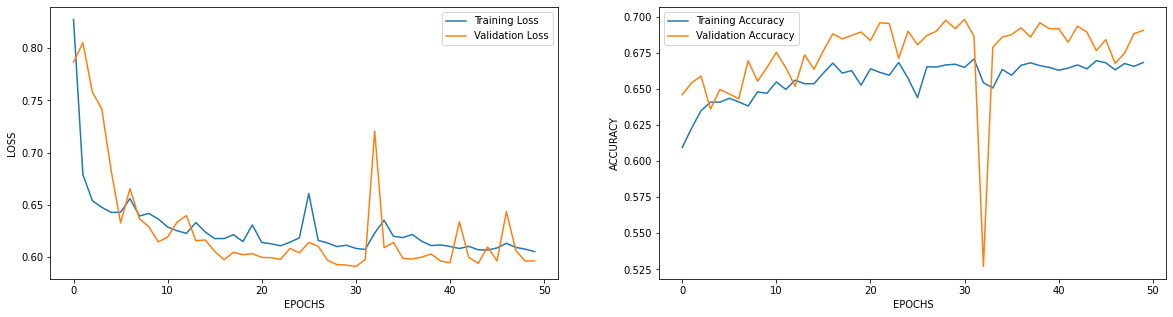

-------------------------------------------------------------------------------------------------------------------------
MODEL NN_2 Last 5 games


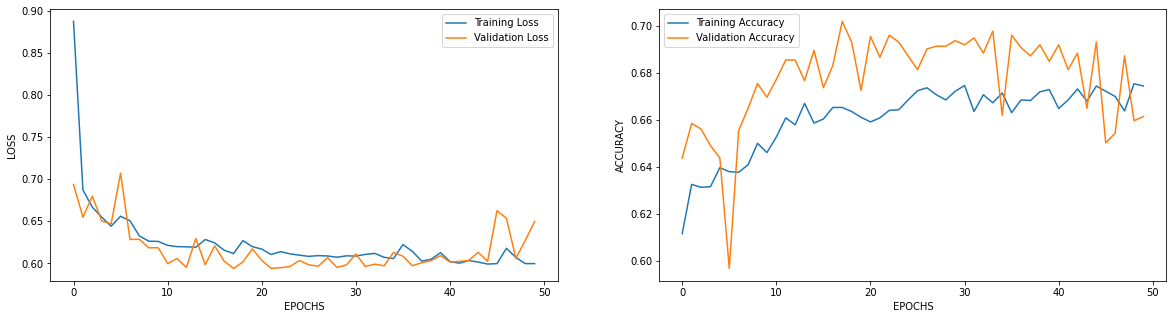

-------------------------------------------------------------------------------------------------------------------------
MODEL NN_3 Last 5 games


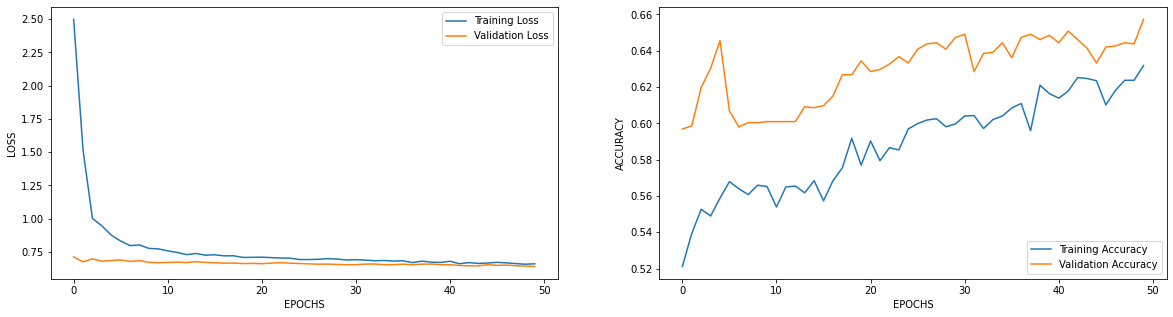

-------------------------------------------------------------------------------------------------------------------------


In [51]:
for k in models.keys():
  if 'NN_' in k and 'Last 5 games' in k:
    print('MODEL '+k)
    hist_df = pd.DataFrame(history[k].history)
    fig,ax = plt.subplots(1,2,figsize=(20,5));
    ax[0].plot(hist_df.index,hist_df.loss,label='Training Loss');
    ax[0].plot(hist_df.index,hist_df.val_loss,label='Validation Loss');
    ax[0].set_xlabel('EPOCHS');
    ax[0].set_ylabel('LOSS');
    ax[0].legend();
    ax[1].plot(hist_df.index,hist_df.accuracy,label='Training Accuracy');
    ax[1].plot(hist_df.index,hist_df.val_accuracy,label='Validation Accuracy');
    ax[1].set_xlabel('EPOCHS');
    ax[1].set_ylabel('ACCURACY');
    ax[1].legend();
    plt.show();
    print('-------------------------------------------------------------------------------------------------------------------------')


In [52]:
for k in models.keys():
  if 'NN_' in k and 'Last 5 games' in k:
    results['ModelName'].append(k)
    results['BestParam'].append('model structure')
    results['BestScore'].append(history[k].history['val_accuracy'][-1])
    results['TestAccuracy'].append(accuracy_score(test_y, np.argmax(models[k].predict(test_X[new_features]),axis=1)))
    results['TestPrecision'].append(precision_score(test_y, np.argmax(models[k].predict(test_X[new_features]),axis=1)))
    results['TestRecall'].append(recall_score(test_y, np.argmax(models[k].predict(test_X[new_features]),axis=1)))
    results['TestF1'].append(f1_score(test_y, np.argmax(models[k].predict(test_X[new_features]),axis=1)))


54/54 [==============================] - 0s 1ms/step


**Repeating the above models using only last 8 games related features**

In [53]:
new_features_8 = ['1_PROB','season'] + [c for c in tmp if 'last8' in c]
new_features_8

['1_PROB',
 'season',
 'home_last8_win_avg',
 'away_last8_win_avg',
 'diff_last8_win_avg',
 'home_last8_win_exp_0.15',
 'away_last8_win_exp_0.15',
 'diff_last8_win_exp_0.15',
 'home_last8_win_exp_0.25',
 'away_last8_win_exp_0.25',
 'diff_last8_win_exp_0.25',
 'home_last8_xG_diff_avg',
 'away_last8_xG_diff_avg',
 'diff_last8_xG_diff_avg',
 'home_last8_xG_diff_exp_0.15',
 'away_last8_xG_diff_exp_0.15',
 'diff_last8_xG_diff_exp_0.15',
 'home_last8_xG_diff_exp_0.25',
 'away_last8_xG_diff_exp_0.25',
 'diff_last8_xG_diff_exp_0.25']

In [54]:
for k in pipes.keys():
  models[k+' Last 8 games'] = GridSearchCV(pipes[k],params[k], cv=2).fit(dev_X[new_features_8],dev_y)
  results['ModelName'].append(k+' Last 8 games')
  results['BestParam'].append(models[k+' Last 8 games'].best_params_)
  results['BestScore'].append(models[k+' Last 8 games'].best_score_)
  results['TestAccuracy'].append(accuracy_score(test_y, models[k+' Last 8 games'].predict(test_X[new_features_8])))
  results['TestPrecision'].append(precision_score(test_y, models[k+' Last 8 games'].predict(test_X[new_features_8])))
  results['TestRecall'].append(recall_score(test_y, models[k+' Last 8 games'].predict(test_X[new_features_8])))
  results['TestF1'].append(f1_score(test_y, models[k+' Last 8 games'].predict(test_X[new_features_8])))
  joblib.dump(models[k+' Last 8 games'],k+' Last 8 games'+'.pkl')
  print(k+' Last 8 games', 'DONE')
  

LogisticRegression Last 8 games DONE
LogisticRegressionWithPCA Last 8 games DONE
RandomForestClassifier Last 8 games DONE
RandomForestClassifierWithPCA Last 8 games DONE
AdaBoostClassifier Last 8 games DONE
AdaBoostClassifierWithPCA Last 8 games DONE
GradientBoostingClassifier Last 8 games DONE
GradientBoostingClassifierWithPCA Last 8 games DONE
DecisionTreeClassifier Last 8 games DONE
DecisionTreeClassifierWithPCA Last 8 games DONE


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC Last 8 games DONE
SVCWithPCA Last 8 games DONE


In [55]:
models['NN_1 Last 8 games'] = Sequential() 
models['NN_1 Last 8 games'].add(Dense(len(new_features_8), activation='relu', input_dim=len(new_features_8)))
models['NN_1 Last 8 games'].add(Dense(2*len(new_features_8), activation='relu'))
models['NN_1 Last 8 games'].add(Dense(len(new_features_8), activation='relu'))
models['NN_1 Last 8 games'].add(Dense(2, activation='linear')) 
models['NN_1 Last 8 games'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_1 Last 8 games'].summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 20)                420       
                                                                 
 dense_37 (Dense)            (None, 40)                840       
                                                                 
 dense_38 (Dense)            (None, 20)                820       
                                                                 
 dense_39 (Dense)            (None, 2)                 42        
                                                                 
Total params: 2,122
Trainable params: 2,122
Non-trainable params: 0
_________________________________________________________________


In [56]:
models['NN_2 Last 8 games'] = Sequential() 
models['NN_2 Last 8 games'].add(Dense(128, activation='relu', input_dim=len(new_features_8)))
models['NN_2 Last 8 games'].add(Dense(64, activation='relu'))
models['NN_2 Last 8 games'].add(Dense(32, activation='relu'))
models['NN_2 Last 8 games'].add(Dense(2, activation='linear')) 
models['NN_2 Last 8 games'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_2 Last 8 games'].summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               2688      
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 2)                 66        
                                                                 
Total params: 13,090
Trainable params: 13,090
Non-trainable params: 0
_________________________________________________________________


In [57]:
models['NN_3 Last 8 games'] = Sequential() 
models['NN_3 Last 8 games'].add(Dense(len(new_features_8), activation='relu', input_dim=len(new_features_8)))
models['NN_3 Last 8 games'].add(Dropout(0.3))
models['NN_3 Last 8 games'].add(Dense(2*len(new_features_8), activation='relu'))
models['NN_3 Last 8 games'].add(Dropout(0.3))
models['NN_3 Last 8 games'].add(Dense(len(new_features_8), activation='relu'))
models['NN_3 Last 8 games'].add(Dropout(0.3))
models['NN_3 Last 8 games'].add(Dense(2, activation='linear')) 
models['NN_3 Last 8 games'].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
models['NN_3 Last 8 games'].summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 20)                420       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_45 (Dense)            (None, 40)                840       
                                                                 
 dropout_10 (Dropout)        (None, 40)                0         
                                                                 
 dense_46 (Dense)            (None, 20)                820       
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_47 (Dense)            (None, 2)               

In [58]:
for k in models.keys():
  if 'NN_' in k and 'Last 8 games' in k:
    history[k] = models[k].fit(train_X[new_features_8], train_y_nn, epochs=50, validation_data=(val_X[new_features_8], val_y_nn))
    print(k, ' DONE')

Epoch 1/50
128/128 [==============================] - 1s 4ms/step - loss: 0.7068 - accuracy: 0.6077 - val_loss: 0.6746 - val_accuracy: 0.6555
Epoch 2/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6331 - val_loss: 0.6423 - val_accuracy: 0.6555
Epoch 3/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6399 - val_loss: 0.6275 - val_accuracy: 0.6643
Epoch 4/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6358 - val_loss: 0.6326 - val_accuracy: 0.6708
Epoch 5/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6444 - val_loss: 0.6163 - val_accuracy: 0.6626
Epoch 6/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6409 - val_loss: 0.6121 - val_accuracy: 0.6631
Epoch 7/50
128/128 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6436 - val_loss: 0.6175 - val_accuracy: 0.6766
Epoch 

MODEL NN_1 Last 8 games


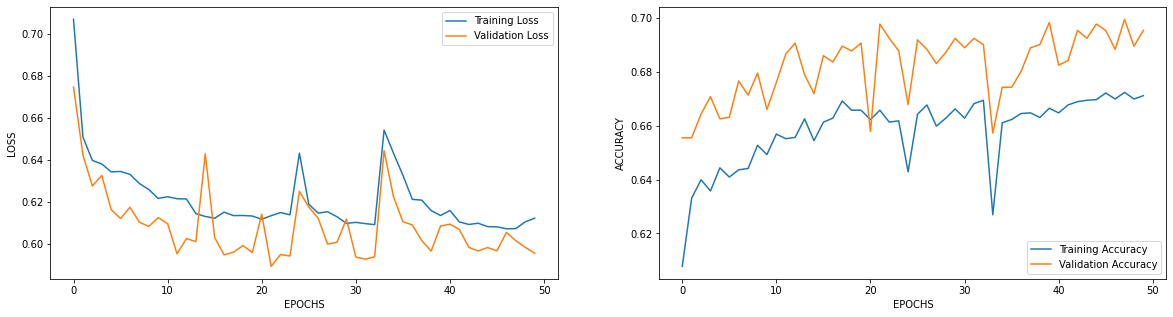

-------------------------------------------------------------------------------------------------------------------------
MODEL NN_2 Last 8 games


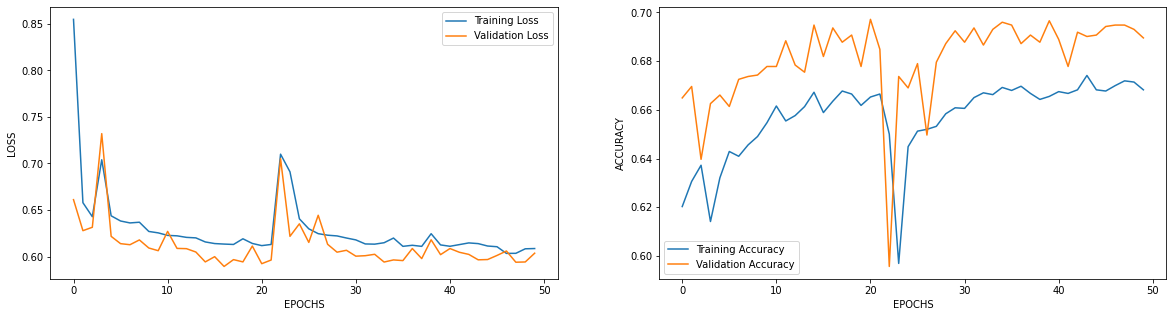

-------------------------------------------------------------------------------------------------------------------------
MODEL NN_3 Last 8 games


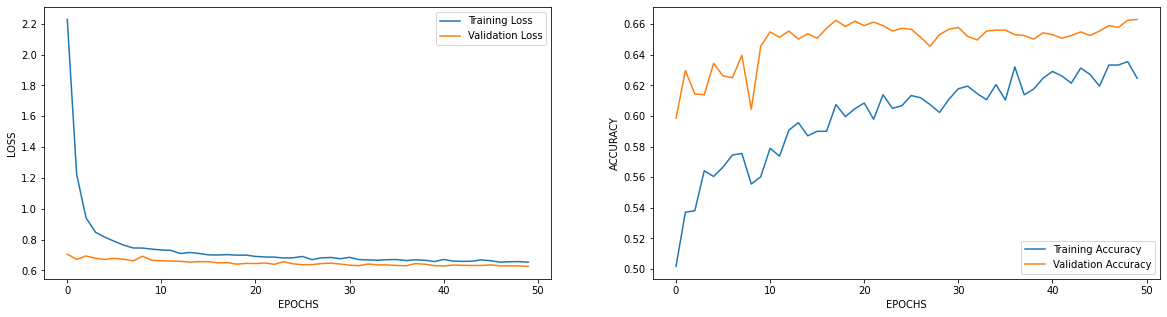

-------------------------------------------------------------------------------------------------------------------------


In [60]:
for k in models.keys():
  if 'NN_' in k and 'Last 8 games' in k:
    print('MODEL '+k)
    hist_df = pd.DataFrame(history[k].history)
    fig,ax = plt.subplots(1,2,figsize=(20,5));
    ax[0].plot(hist_df.index,hist_df.loss,label='Training Loss');
    ax[0].plot(hist_df.index,hist_df.val_loss,label='Validation Loss');
    ax[0].set_xlabel('EPOCHS');
    ax[0].set_ylabel('LOSS');
    ax[0].legend();
    ax[1].plot(hist_df.index,hist_df.accuracy,label='Training Accuracy');
    ax[1].plot(hist_df.index,hist_df.val_accuracy,label='Validation Accuracy');
    ax[1].set_xlabel('EPOCHS');
    ax[1].set_ylabel('ACCURACY');
    ax[1].legend();
    plt.show();
    print('-------------------------------------------------------------------------------------------------------------------------')


In [61]:
for k in models.keys():
  if 'NN_' in k and 'Last 8 games' in k:
    results['ModelName'].append(k)
    results['BestParam'].append('model structure')
    results['BestScore'].append(history[k].history['val_accuracy'][-1])
    results['TestAccuracy'].append(accuracy_score(test_y, np.argmax(models[k].predict(test_X[new_features_8]),axis=1)))
    results['TestPrecision'].append(precision_score(test_y, np.argmax(models[k].predict(test_X[new_features_8]),axis=1)))
    results['TestRecall'].append(recall_score(test_y, np.argmax(models[k].predict(test_X[new_features_8]),axis=1)))
    results['TestF1'].append(f1_score(test_y, np.argmax(models[k].predict(test_X[new_features_8]),axis=1)))


54/54 [==============================] - 0s 1ms/step


**CalibratedCV**

In [62]:
scaler1 = StandardScaler()
train_X_scaled = scaler1.fit_transform(train_X)
val_X_scaled = scaler1.transform(val_X)
test_X_scaled = scaler1.transform(test_X)
cal_logr = CalibratedClassifierCV(base_estimator=LogisticRegression(max_iter=5000), cv=5)
cal_logr.fit(train_X_scaled,train_y)
cal_logr.score(test_X_scaled,test_y)

0.6641221374045801

In [63]:
cal_ada = CalibratedClassifierCV(base_estimator=AdaBoostClassifier(), cv=5)
cal_ada.fit(train_X_scaled,train_y)
cal_ada.score(test_X_scaled,test_y)

0.6089254257193188

In [64]:
cal_rfc = CalibratedClassifierCV(base_estimator=RandomForestClassifier(), cv=5)
cal_rfc.fit(train_X_scaled,train_y)
cal_rfc.score(test_X_scaled,test_y)

0.6688197298884322

In [65]:
cal_gbc = CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(), cv=5)
cal_gbc.fit(train_X_scaled,train_y)
cal_gbc.score(test_X_scaled,test_y)

0.6705813270698767

In [66]:
cal_dtc = CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(), cv=5)
cal_dtc.fit(train_X_scaled,train_y)
cal_dtc.score(test_X_scaled,test_y)

0.5960070463887258

CalibratedCV doesn't seem to improve the performance.

**Results**

In [67]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth', None)

In [68]:
results_df = pd.DataFrame(data=results)
results_df

ModelName  \
0                                      LogisticRegression   
1                               LogisticRegressionWithPCA   
2                                  RandomForestClassifier   
3                           RandomForestClassifierWithPCA   
4                                      AdaBoostClassifier   
5                               AdaBoostClassifierWithPCA   
6                              GradientBoostingClassifier   
7                       GradientBoostingClassifierWithPCA   
8                                  DecisionTreeClassifier   
9                           DecisionTreeClassifierWithPCA   
10                                                    SVC   
11                                             SVCWithPCA   
12                      LogisticRegression Top 5 features   
13               LogisticRegressionWithPCA Top 5 features   
14                  RandomForestClassifier Top 5 features   
15           RandomForestClassifierWithPCA Top 5 features   
16                      AdaBoostClassifier Top 5 features   
17               AdaBoostClassifierWithPCA Top 5 features   
18              GradientBoostingClassifier Top 5 features   
19       GradientBoostingClassifierWithPCA Top 5 features   
20                  DecisionTreeClassifier Top 5 features   
21           DecisionTreeClassifierWithPCA Top 5 features   
22                                     SVC Top 5 features   
23                              SVCWithPCA Top 5 features   
24                                                   NN_1   
25                                                   NN_2   
26                                                   NN_3   
27                 LogisticRegression cumulative features   
28          LogisticRegressionWithPCA cumulative features   
29             RandomForestClassifier cumulative features   
30      RandomForestClassifierWithPCA cumulative features   
31                 AdaBoostClassifier cumulative features   
32          AdaBoostClassifierWithPCA cumulative features   
33         GradientBoostingClassifier cumulative features   
34  GradientBoostingClassifierWithPCA cumulative features   
35             DecisionTreeClassifier cumulative features   
36      DecisionTreeClassifierWithPCA cumulative features   
37                                SVC cumulative features   
38                         SVCWithPCA cumulative features   
39                        LogisticRegression Last 5 games   
40                 LogisticRegressionWithPCA Last 5 games   
41                    RandomForestClassifier Last 5 games   
42             RandomForestClassifierWithPCA Last 5 games   
43                        AdaBoostClassifier Last 5 games   
44                 AdaBoostClassifierWithPCA Last 5 games   
45                GradientBoostingClassifier Last 5 games   
46         GradientBoostingClassifierWithPCA Last 5 games   
47                    DecisionTreeClassifier Last 5 games   
48             DecisionTreeClassifierWithPCA Last 5 games   
49                                       SVC Last 5 games   
50                                SVCWithPCA Last 5 games   
51                                      NN_1 Last 5 games   
52                                      NN_2 Last 5 games   
53                                      NN_3 Last 5 games   
54                        LogisticRegression Last 8 games   
55                 LogisticRegressionWithPCA Last 8 games   
56                    RandomForestClassifier Last 8 games   
57             RandomForestClassifierWithPCA Last 8 games   
58                        AdaBoostClassifier Last 8 games   
59                 AdaBoostClassifierWithPCA Last 8 games   
60                GradientBoostingClassifier Last 8 games   
61         GradientBoostingClassifierWithPCA Last 8 games   
62                    DecisionTreeClassifier Last 8 games   
63             DecisionTreeClassifierWithPCA Last 8 games   
64                                       SVC Last 8 games   
65                    

**Precision Recall Curves**

Models using all features :
54/54 [==============================] - 0s 1ms/step


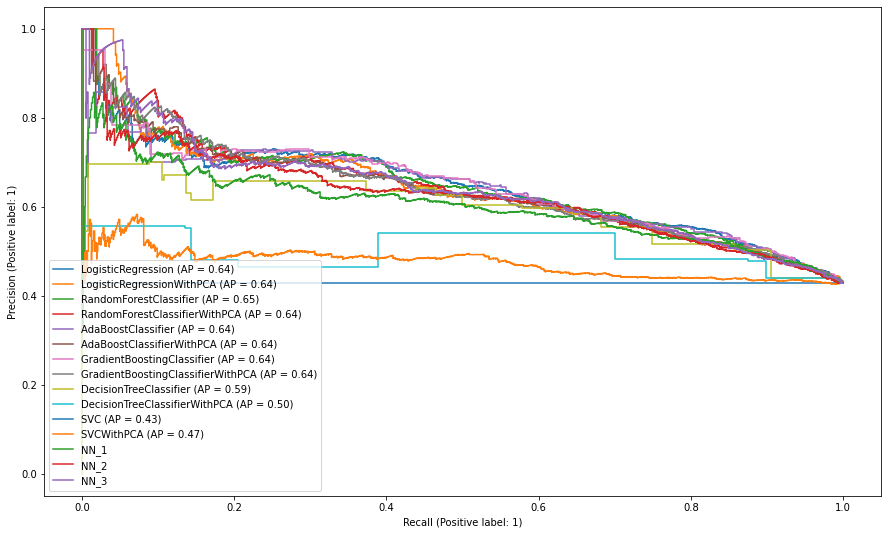

In [69]:
print('Models using all features :')
fig,ax = plt.subplots(1,1,figsize=(15,9));
for k in models.keys():
  if 'Last' not in k and 'Top' not in k and 'cumulative' not in k:
    if 'NN_' not in k:
      disp = PrecisionRecallDisplay.from_estimator(models[k],test_X, test_y,name=k,ax=ax);
    else:
      precision1,recall1,thresholds1 = precision_recall_curve(test_y,models[k].predict(test_X)[:,1])
      disp = PrecisionRecallDisplay(precision=precision1,recall=recall1,pos_label=1);
      disp.plot(ax,label=k);

Models using Top 5 features :


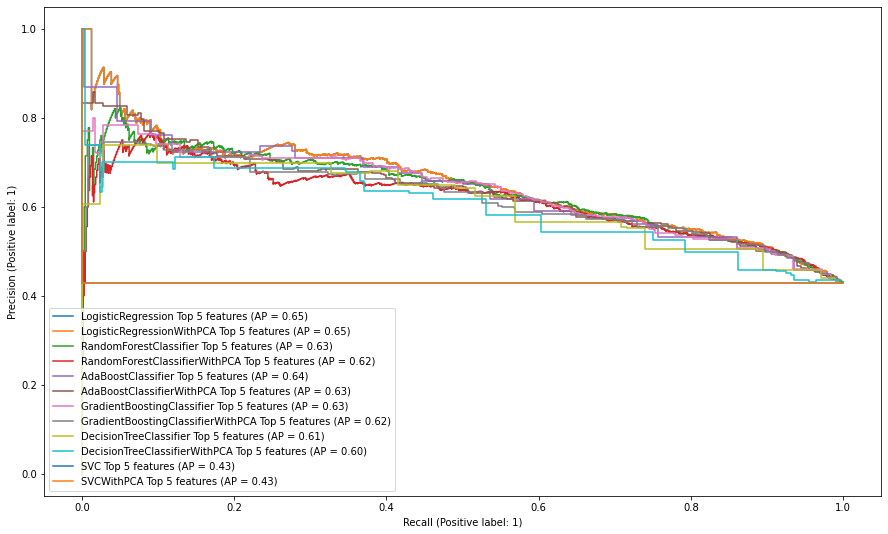

In [70]:
print('Models using Top 5 features :')
fig,ax = plt.subplots(1,1,figsize=(15,9));
for k in models.keys():
  if 'Top' in k:
    if 'NN_' not in k:
      disp = PrecisionRecallDisplay.from_estimator(models[k],test_X[top_5_features], test_y,name=k,ax=ax);
      #disp.plot(ax);
    else:
      precision1,recall1,thresholds1 = precision_recall_curve(test_y,models[k].predict(test_X[top_5_features])[:,1])
      disp = PrecisionRecallDisplay(precision=precision1,recall=recall1,pos_label=1);
      disp.plot(ax,label=k);

Models using cumulative features :
54/54 [==============================] - 0s 1ms/step


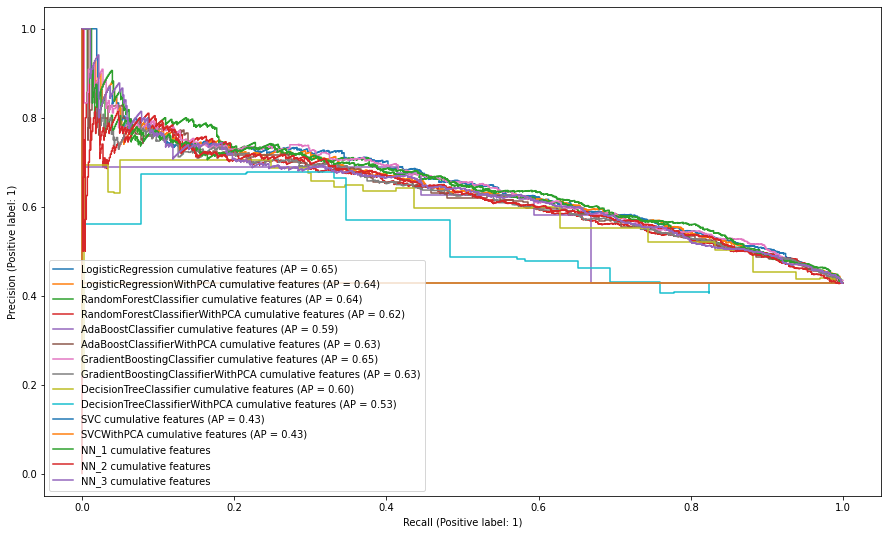

In [71]:
print('Models using cumulative features :')
fig,ax = plt.subplots(1,1,figsize=(15,9));
for k in models.keys():
  if 'cumulative features' in k:
    if 'NN_' not in k:
      disp = PrecisionRecallDisplay.from_estimator(models[k],test_X[cum_features], test_y,name=k,ax=ax);
      #disp.plot(ax);
    else:
      precision1,recall1,thresholds1 = precision_recall_curve(test_y,models[k].predict(test_X[cum_features])[:,1])
      disp = PrecisionRecallDisplay(precision=precision1,recall=recall1,pos_label=1);
      disp.plot(ax,label=k);

Models using Last 5 games related features :
54/54 [==============================] - 0s 1ms/step


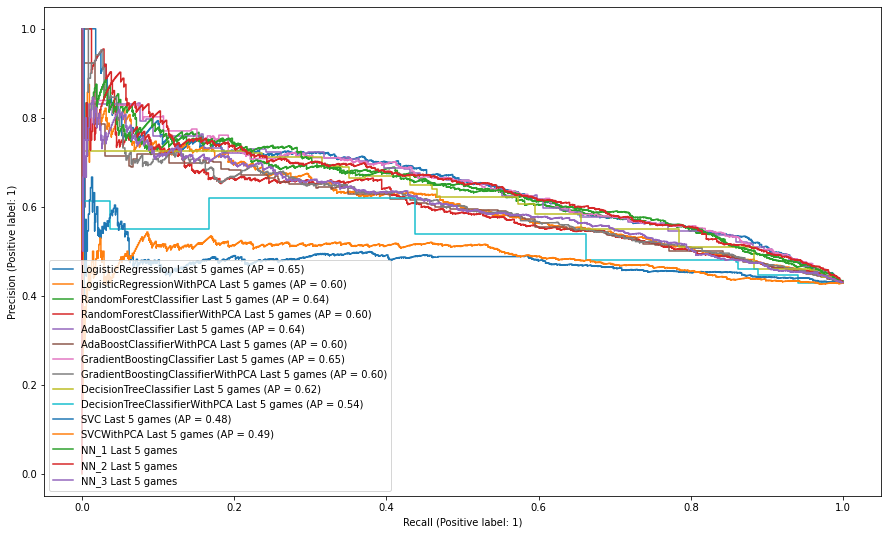

In [72]:
print('Models using Last 5 games related features :')
fig,ax = plt.subplots(1,1,figsize=(15,9));
for k in models.keys():
  if 'Last 5 games' in k:
    if 'NN_' not in k:
      disp = PrecisionRecallDisplay.from_estimator(models[k],test_X[new_features], test_y,name=k,ax=ax);
      #disp.plot(ax);
    else:
      precision1,recall1,thresholds1 = precision_recall_curve(test_y,models[k].predict(test_X[new_features])[:,1])
      disp = PrecisionRecallDisplay(precision=precision1,recall=recall1,pos_label=1);
      disp.plot(ax,label=k);

Models using Last 8 games related features :
54/54 [==============================] - 0s 2ms/step


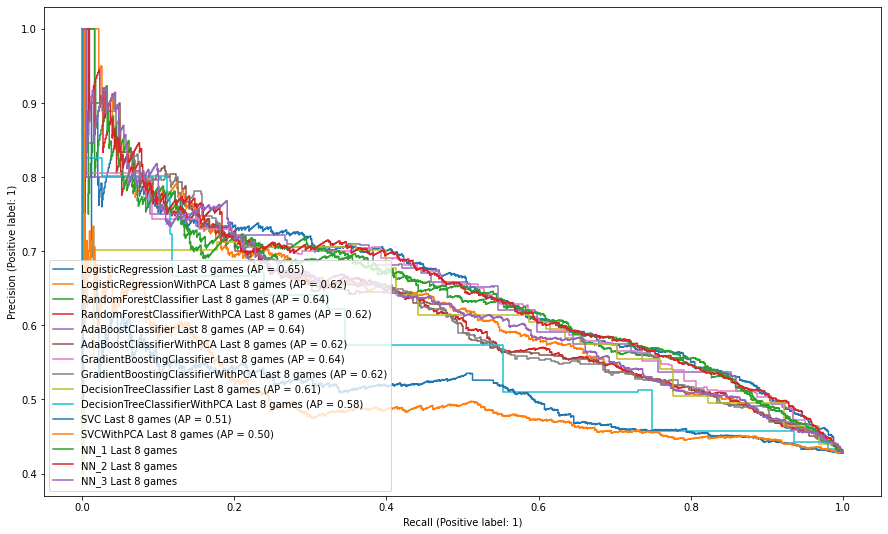

In [73]:
print('Models using Last 8 games related features :')
fig,ax = plt.subplots(1,1,figsize=(15,9));
for k in models.keys():
  if 'Last 8 games' in k:
    if 'NN_' not in k:
      disp = PrecisionRecallDisplay.from_estimator(models[k],test_X[new_features_8], test_y,name=k,ax=ax);
      #disp.plot(ax);
    else:
      precision1,recall1,thresholds1 = precision_recall_curve(test_y,models[k].predict(test_X[new_features_8])[:,1])
      disp = PrecisionRecallDisplay(precision=precision1,recall=recall1,pos_label=1);
      disp.plot(ax,label=k);

**Betting Calculations**

In [74]:
train_X_1_MULTIPLIER = (1/train_X['1_PROB']).tolist()
val_X_1_MULTIPLIER = (1/val_X['1_PROB']).tolist()
test_X_1_MULTIPLIER = (1/test_X['1_PROB']).tolist()

In [75]:
betting_amount_C = 1000

In [76]:
profit_loss_dict={}
for k in models.keys():
  profit_loss_dict[k] = []

In [77]:
for k in models.keys():
  if 'Last' not in k and 'Top' not in k and 'cumulative' not in k:
    if 'NN_' not in k:
      y_pred = models[k].predict(test_X)
  
  if 'cumulative' in k:
    if 'NN_' not in k:
      y_pred = models[k].predict(test_X[cum_features])
    else:
      y_pred = np.argmax(models[k].predict(test_X[cum_features]),axis=1)

  if 'Top' in k:
    if 'NN_' not in k:
      y_pred = models[k].predict(test_X[top_5_features])
    else:
      y_pred = np.argmax(models[k].predict(test_X[top_5_features]),axis=1)
      
  if 'Last 5 games' in k:
    if 'NN_' not in k:
      y_pred = models[k].predict(test_X[new_features])
    else:
      y_pred = np.argmax(models[k].predict(test_X[new_features]),axis=1)
          
  if 'Last 8 games' in k:
    if 'NN_' not in k:
      y_pred = models[k].predict(test_X[new_features_8])
    else:
      y_pred = np.argmax(models[k].predict(test_X[new_features_8]),axis=1)

  for i in range(len(y_pred)):
    if y_pred[i]==test_y.tolist()[i]:
      profit_loss_dict[k].append((test_X_1_MULTIPLIER[i]-1) *betting_amount_C)
    else:
      profit_loss_dict[k].append(-1*betting_amount_C)

  print('AMOUNT CALCULATED FOR MODEL '+k)

AMOUNT CALCULATED FOR MODEL LogisticRegression
AMOUNT CALCULATED FOR MODEL LogisticRegressionWithPCA
AMOUNT CALCULATED FOR MODEL RandomForestClassifier
AMOUNT CALCULATED FOR MODEL RandomForestClassifierWithPCA
AMOUNT CALCULATED FOR MODEL AdaBoostClassifier
AMOUNT CALCULATED FOR MODEL AdaBoostClassifierWithPCA
AMOUNT CALCULATED FOR MODEL GradientBoostingClassifier
AMOUNT CALCULATED FOR MODEL GradientBoostingClassifierWithPCA
AMOUNT CALCULATED FOR MODEL DecisionTreeClassifier
AMOUNT CALCULATED FOR MODEL DecisionTreeClassifierWithPCA
AMOUNT CALCULATED FOR MODEL SVC
AMOUNT CALCULATED FOR MODEL SVCWithPCA
AMOUNT CALCULATED FOR MODEL LogisticRegression Top 5 features
AMOUNT CALCULATED FOR MODEL LogisticRegressionWithPCA Top 5 features
AMOUNT CALCULATED FOR MODEL RandomForestClassifier Top 5 features
AMOUNT CALCULATED FOR MODEL RandomForestClassifierWithPCA Top 5 features
AMOUNT CALCULATED FOR MODEL AdaBoostClassifier Top 5 features
AMOUNT CALCULATED FOR MODEL AdaBoostClassifierWithPCA Top 5 

In [78]:
betting_amount_df = pd.DataFrame(data=profit_loss_dict)
betting_amount_df

LogisticRegression  LogisticRegressionWithPCA  RandomForestClassifier  \
0           -1000.000000               -1000.000000            -1000.000000   
1             229.885057                 229.885057              229.885057   
2           -1000.000000                 869.565217            -1000.000000   
3           -1000.000000               -1000.000000            -1000.000000   
4           -1000.000000               -1000.000000            -1000.000000   
5           -1000.000000               -1000.000000            -1000.000000   
6            1060.000000                1060.000000             1060.000000   
7            1540.000000                1540.000000             1540.000000   
8            2520.000000                2520.000000             2520.000000   
9             490.196078                 490.196078              490.196078   
10           8360.000000                8360.000000             8360.000000   
11          -1000.000000               -1000.000000            -1000.000000   
12           2200.000000                2200.000000             2200.000000   
13          -1000.000000               -1000.000000            -1000.000000   
14           1620.000000                1620.000000             1620.000000   
15           1120.000000                1120.000000             1120.000000   
16          -1000.000000               -1000.000000            -1000.000000   
17          -1000.000000               -1000.000000            -1000.000000   
18           2310.000000                2310.000000             2310.000000   
19          -1000.000000               -1000.000000            -1000.000000   
20            250.000000                 250.000000              250.000000   
21           1250.000000               -1000.000000             1250.000000   
22           1920.000000                1920.000000             1920.000000   
23           3470.000000                3470.000000             3470.000000   
24            740.740741               -1000.000000            -1000.000000   
25            130.039012                 130.039012              130.039012   
26          -1000.000000               -1000.000000            -1000.000000   
27            289.855072                 289.855072              289.855072   
28          -1000.000000                 460.829493              460.829493   
29          -1000.000000               -1000.000000            -1000.000000   
30          -1000.000000               -1000.000000            -1000.000000   
31            130.039012                 130.039012              130.039012   
32            680.272109               -1000.000000            -1000.000000   
33           1350.000000                1350.000000             1350.000000   
34           4550.000000                4550.000000             4550.000000   
35           2360.000000                2360.000000             2360.000000   
36           4370.000000                4370.000000             4370.000000   
37           1940.000000                1940.000000             1940.000000   
38           3590.000000                3590.000000             3590.000000   
39           1600.000000                1600.000000             1600.000000   
40           2390.000000                2390.000000             2390.000000   
41          -1000.000000               -1000.000000            -1000.000000   
42          -1000.000000               -1000.000000            -1000.000000   
43           3610.000000                3610.000000             3610.000000   
44            420.168067                 420.168067              420.168067   
45           4590.000000                4590.000000             4590.000000   
46          -1000.000000               -1000.000000            -1000.000000   
47           3210.000000                3210.000000             3210.000000   
48          -1000.000000               -1000.000000            -1000.000000   
49            349.650350                 349.650350     

In [79]:
total_amount_after_betting = [(betting_amount_df.columns[i],betting_amount_df.sum().values[i]) for i in range(len(betting_amount_df.sum().values))]

In [80]:
total_amount_after_betting

[('LogisticRegression', 1773268.0359926187),
 ('LogisticRegressionWithPCA', 1734856.8625205136),
 ('RandomForestClassifier', 1764922.398204995),
 ('RandomForestClassifierWithPCA', 1755930.3670863947),
 ('AdaBoostClassifier', 1797739.2399023334),
 ('AdaBoostClassifierWithPCA', 1720933.5783395167),
 ('GradientBoostingClassifier', 1786354.2134903558),
 ('GradientBoostingClassifierWithPCA', 1729804.0081321532),
 ('DecisionTreeClassifier', 1705728.996028773),
 ('DecisionTreeClassifierWithPCA', 1548429.8935853648),
 ('SVC', 1542684.6899545556),
 ('SVCWithPCA', 1542684.6899545556),
 ('LogisticRegression Top 5 features', 1791886.2795368354),
 ('LogisticRegressionWithPCA Top 5 features', 1791886.2795368354),
 ('RandomForestClassifier Top 5 features', 1784156.2045204681),
 ('RandomForestClassifierWithPCA Top 5 features', 1754079.966820878),
 ('AdaBoostClassifier Top 5 features', 1797531.3939443696),
 ('AdaBoostClassifierWithPCA Top 5 features', 1766292.2985268715),
 ('GradientBoostingClassifier 

In [81]:
amount_betted_in_each_match = [ betting_amount_C for _ in range(len(test_X))] 

In [82]:
total_amount_after_betting.sort(key=lambda k:k[1], reverse=True)
total_amount_after_betting

[('AdaBoostClassifier Last 8 games', 1803426.0561140552),
 ('AdaBoostClassifier Last 5 games', 1799582.5713364282),
 ('AdaBoostClassifier', 1797739.2399023334),
 ('AdaBoostClassifier Top 5 features', 1797531.3939443696),
 ('LogisticRegression Top 5 features', 1791886.2795368354),
 ('LogisticRegressionWithPCA Top 5 features', 1791886.2795368354),
 ('LogisticRegression Last 5 games', 1791466.466034527),
 ('NN_2 Last 8 games', 1791283.8892656593),
 ('GradientBoostingClassifier Last 5 games', 1787812.6199610033),
 ('LogisticRegression cumulative features', 1787750.2583480552),
 ('GradientBoostingClassifier Last 8 games', 1787112.8875534278),
 ('GradientBoostingClassifier', 1786354.2134903558),
 ('RandomForestClassifier Top 5 features', 1784156.2045204681),
 ('GradientBoostingClassifier cumulative features', 1783451.981250252),
 ('LogisticRegression Last 8 games', 1778805.7866688794),
 ('GradientBoostingClassifier Top 5 features', 1775812.0638837116),
 ('AdaBoostClassifier cumulative featur

In [83]:
profit_loss_made = []
for v in total_amount_after_betting:
  profit_loss_made.append((v[0], v[1]-sum(amount_betted_in_each_match)))
profit_loss_made

[('AdaBoostClassifier Last 8 games', 100426.05611405522),
 ('AdaBoostClassifier Last 5 games', 96582.57133642817),
 ('AdaBoostClassifier', 94739.23990233336),
 ('AdaBoostClassifier Top 5 features', 94531.39394436963),
 ('LogisticRegression Top 5 features', 88886.27953683538),
 ('LogisticRegressionWithPCA Top 5 features', 88886.27953683538),
 ('LogisticRegression Last 5 games', 88466.46603452694),
 ('NN_2 Last 8 games', 88283.88926565927),
 ('GradientBoostingClassifier Last 5 games', 84812.6199610033),
 ('LogisticRegression cumulative features', 84750.25834805518),
 ('GradientBoostingClassifier Last 8 games', 84112.88755342783),
 ('GradientBoostingClassifier', 83354.21349035576),
 ('RandomForestClassifier Top 5 features', 81156.20452046813),
 ('GradientBoostingClassifier cumulative features', 80451.98125025211),
 ('LogisticRegression Last 8 games', 75805.78666887945),
 ('GradientBoostingClassifier Top 5 features', 72812.06388371158),
 ('AdaBoostClassifier cumulative features', 71399.853

In [84]:
profit_loss_made_percentage = []
for v in total_amount_after_betting:
  profit_loss_made_percentage.append((v[0], round(((v[1]-sum(amount_betted_in_each_match))/sum(amount_betted_in_each_match))*100,1)))
profit_loss_made_percentage

[('AdaBoostClassifier Last 8 games', 5.9),
 ('AdaBoostClassifier Last 5 games', 5.7),
 ('AdaBoostClassifier', 5.6),
 ('AdaBoostClassifier Top 5 features', 5.6),
 ('LogisticRegression Top 5 features', 5.2),
 ('LogisticRegressionWithPCA Top 5 features', 5.2),
 ('LogisticRegression Last 5 games', 5.2),
 ('NN_2 Last 8 games', 5.2),
 ('GradientBoostingClassifier Last 5 games', 5.0),
 ('LogisticRegression cumulative features', 5.0),
 ('GradientBoostingClassifier Last 8 games', 4.9),
 ('GradientBoostingClassifier', 4.9),
 ('RandomForestClassifier Top 5 features', 4.8),
 ('GradientBoostingClassifier cumulative features', 4.7),
 ('LogisticRegression Last 8 games', 4.5),
 ('GradientBoostingClassifier Top 5 features', 4.3),
 ('AdaBoostClassifier cumulative features', 4.2),
 ('LogisticRegression', 4.1),
 ('AdaBoostClassifierWithPCA Top 5 features', 3.7),
 ('RandomForestClassifier', 3.6),
 ('RandomForestClassifier cumulative features', 3.5),
 ('DecisionTreeClassifier Top 5 features', 3.4),
 ('NN_1 

In [85]:
profit_loss_made_percentage_dict={}

for v in profit_loss_made_percentage:
  profit_loss_made_percentage_dict[v[0]] = v[1]

In [86]:
results_df['Profit_Loss_percentage'] = [0.0 for _ in range(len(results_df))]
results_df['Acc_percentage'] = [0.0 for _ in range(len(results_df))]

for i,r in results_df.iterrows():
  results_df.at[i,'Profit_Loss_percentage'] = profit_loss_made_percentage_dict[r['ModelName']]
  results_df.at[i,'Acc_percentage'] = round(r['TestAccuracy']*100,1)

In [87]:
results_df

ModelName  \
0                                      LogisticRegression   
1                               LogisticRegressionWithPCA   
2                                  RandomForestClassifier   
3                           RandomForestClassifierWithPCA   
4                                      AdaBoostClassifier   
5                               AdaBoostClassifierWithPCA   
6                              GradientBoostingClassifier   
7                       GradientBoostingClassifierWithPCA   
8                                  DecisionTreeClassifier   
9                           DecisionTreeClassifierWithPCA   
10                                                    SVC   
11                                             SVCWithPCA   
12                      LogisticRegression Top 5 features   
13               LogisticRegressionWithPCA Top 5 features   
14                  RandomForestClassifier Top 5 features   
15           RandomForestClassifierWithPCA Top 5 features   
16                      AdaBoostClassifier Top 5 features   
17               AdaBoostClassifierWithPCA Top 5 features   
18              GradientBoostingClassifier Top 5 features   
19       GradientBoostingClassifierWithPCA Top 5 features   
20                  DecisionTreeClassifier Top 5 features   
21           DecisionTreeClassifierWithPCA Top 5 features   
22                                     SVC Top 5 features   
23                              SVCWithPCA Top 5 features   
24                                                   NN_1   
25                                                   NN_2   
26                                                   NN_3   
27                 LogisticRegression cumulative features   
28          LogisticRegressionWithPCA cumulative features   
29             RandomForestClassifier cumulative features   
30      RandomForestClassifierWithPCA cumulative features   
31                 AdaBoostClassifier cumulative features   
32          AdaBoostClassifierWithPCA cumulative features   
33         GradientBoostingClassifier cumulative features   
34  GradientBoostingClassifierWithPCA cumulative features   
35             DecisionTreeClassifier cumulative features   
36      DecisionTreeClassifierWithPCA cumulative features   
37                                SVC cumulative features   
38                         SVCWithPCA cumulative features   
39                        LogisticRegression Last 5 games   
40                 LogisticRegressionWithPCA Last 5 games   
41                    RandomForestClassifier Last 5 games   
42             RandomForestClassifierWithPCA Last 5 games   
43                        AdaBoostClassifier Last 5 games   
44                 AdaBoostClassifierWithPCA Last 5 games   
45                GradientBoostingClassifier Last 5 games   
46         GradientBoostingClassifierWithPCA Last 5 games   
47                    DecisionTreeClassifier Last 5 games   
48             DecisionTreeClassifierWithPCA Last 5 games   
49                                       SVC Last 5 games   
50                                SVCWithPCA Last 5 games   
51                                      NN_1 Last 5 games   
52                                      NN_2 Last 5 games   
53                                      NN_3 Last 5 games   
54                        LogisticRegression Last 8 games   
55                 LogisticRegressionWithPCA Last 8 games   
56                    RandomForestClassifier Last 8 games   
57             RandomForestClassifierWithPCA Last 8 games   
58                        AdaBoostClassifier Last 8 games   
59                 AdaBoostClassifierWithPCA Last 8 games   
60                GradientBoostingClassifier Last 8 games   
61         GradientBoostingClassifierWithPCA Last 8 games   
62                    DecisionTreeClassifier Last 8 games   
63             DecisionTreeClassifierWithPCA Last 8 games   
64                                       SVC Last 8 games   
65                    

In [88]:
results_df = results_df.sort_values(by=['Profit_Loss_percentage'],ascending=False)
results_df.head(5)[['ModelName','Profit_Loss_percentage','Acc_percentage']]

ModelName  Profit_Loss_percentage  \
58           AdaBoostClassifier Last 8 games                     5.9   
43           AdaBoostClassifier Last 5 games                     5.7   
16         AdaBoostClassifier Top 5 features                     5.6   
4                         AdaBoostClassifier                     5.6   
13  LogisticRegressionWithPCA Top 5 features                     5.2   

    Acc_percentage  
58            68.0  
43            67.9  
16            67.8  
4             67.8  
13            67.6

In [89]:
results_df = results_df.sort_values(by=['Acc_percentage'],ascending=False)
results_df.head(5)[['ModelName','Profit_Loss_percentage','Acc_percentage']]

ModelName  Profit_Loss_percentage  \
58           AdaBoostClassifier Last 8 games                     5.9   
43           AdaBoostClassifier Last 5 games                     5.7   
16         AdaBoostClassifier Top 5 features                     5.6   
4                         AdaBoostClassifier                     5.6   
13  LogisticRegressionWithPCA Top 5 features                     5.2   

    Acc_percentage  
58            68.0  
43            67.9  
16            67.8  
4             67.8  
13            67.6

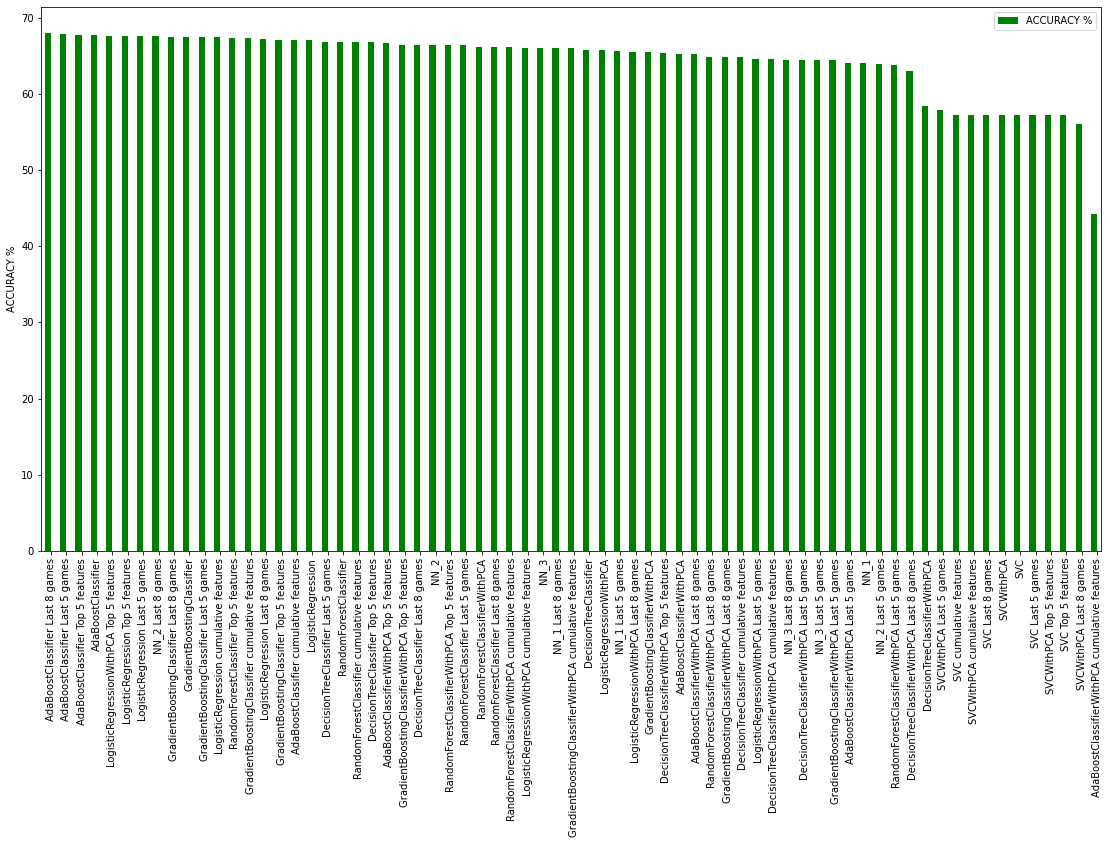

In [90]:
fig = plt.figure(figsize=(19,10)) 
ax = fig.add_subplot(111) 
width = 0.4
results_df.Acc_percentage.plot(kind='bar', color='green', ax=ax, width=width, position=1,label='ACCURACY %')
ax.set_ylabel('ACCURACY %')
ax.set_xticklabels(results_df.ModelName)
ax.legend()
plt.show()

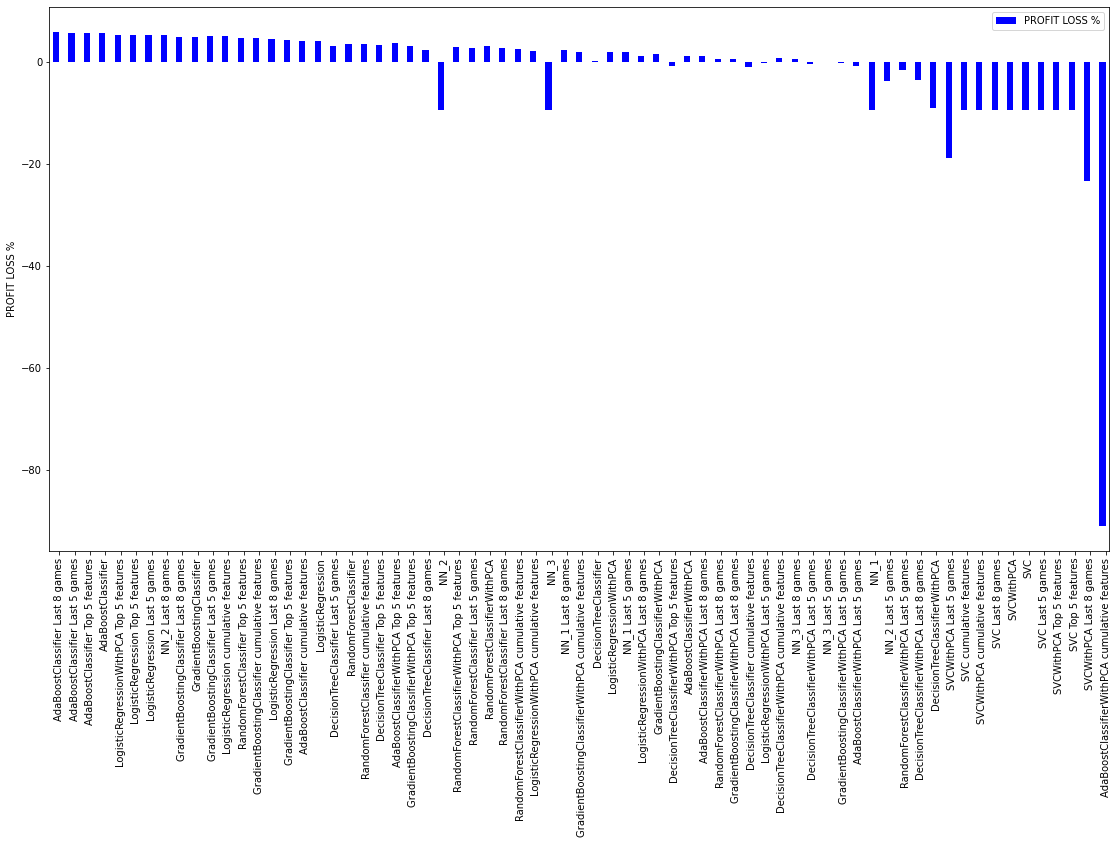

In [91]:
fig = plt.figure(figsize=(19,10)) 
ax = fig.add_subplot(111) 
width = 0.4
results_df.Profit_Loss_percentage.plot(kind='bar', color='blue', ax=ax, width=width, position=1,label='PROFIT LOSS %')
ax.set_ylabel('PROFIT LOSS %')
ax.set_xticklabels(results_df.ModelName)
ax.legend()
plt.show()

**Comparing best and worst performing model**

In [92]:
compare_df = pd.concat([results_df.head(1), results_df.tail(1)])
compare_df = compare_df[['ModelName','BestParam','Acc_percentage','Profit_Loss_percentage']]
compare_df

ModelName  \
58                AdaBoostClassifier Last 8 games   
32  AdaBoostClassifierWithPCA cumulative features   

                                                                         BestParam  \
58                          {'ada__learning_rate': 0.05, 'ada__n_estimators': 100}   
32  {'ada__learning_rate': 0.05, 'ada__n_estimators': 300, 'pca__n_components': 4}   

    Acc_percentage  Profit_Loss_percentage  
58            68.0                     5.9  
32            44.2                   -91.1

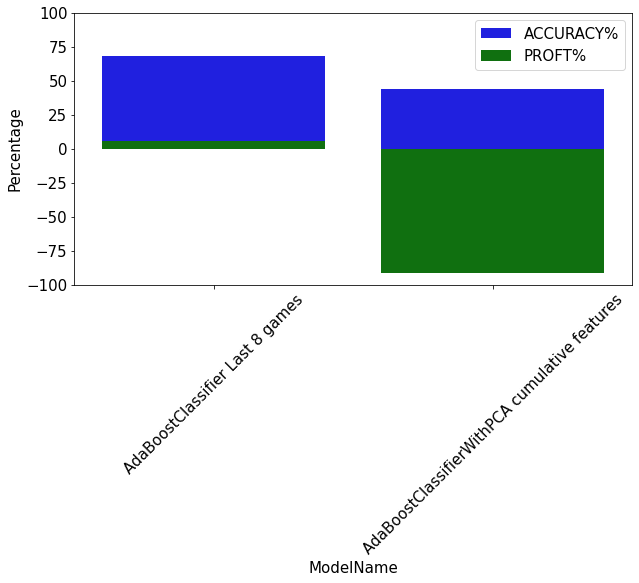

In [93]:
plt.rcParams["font.size"] = 15
fig,ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(data=compare_df, x="ModelName", y='Acc_percentage',ax=ax,color='blue',label='ACCURACY%');
sns.barplot(data=compare_df, x="ModelName", y='Profit_Loss_percentage',ax=ax,color='green',label='PROFT%');
ax.set_ylabel('Percentage')
ax.set_xticklabels(compare_df.ModelName,rotation=45)
ax.set_ylim(-100,100);
plt.legend()
plt.show()

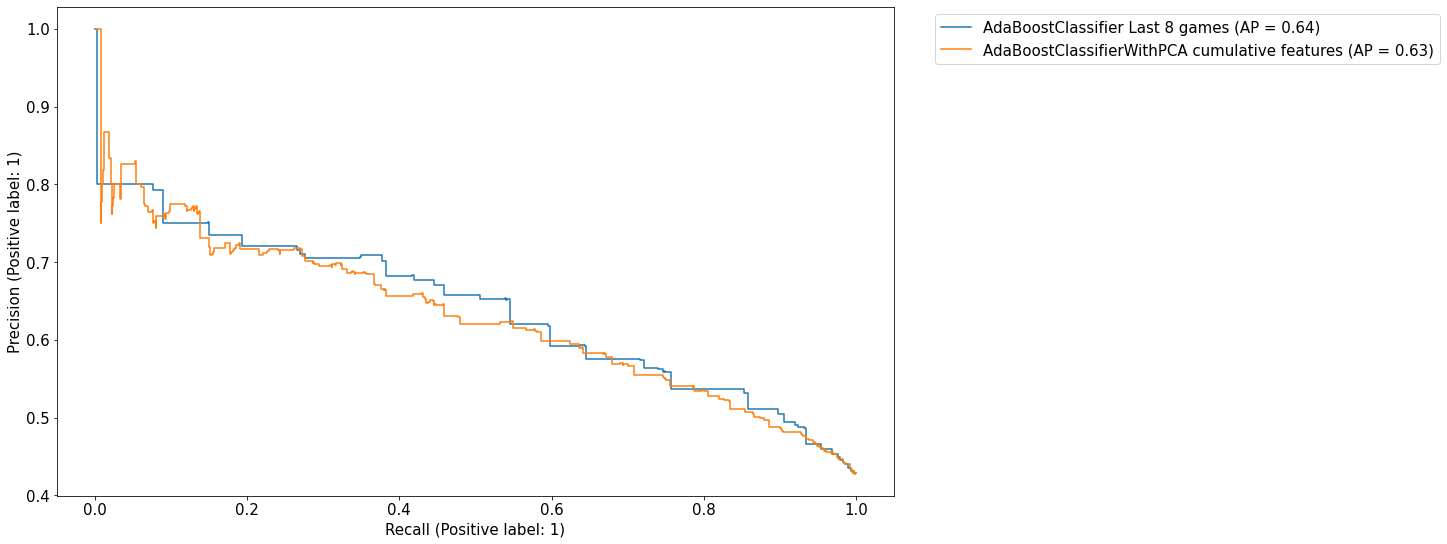

In [94]:
plt.rcParams["font.size"] = 15

fig,ax = plt.subplots(1,1,figsize=(15,9));
for i,r in compare_df.iterrows():

  list_features = []
  if 'Last 8' in r['ModelName']:
    list_features = new_features_8
  elif 'Top 5' in r['ModelName']:
    list_features = top_5_features
  elif 'Last 5' in r['ModelName']:
    list_features = new_features
  elif 'cumulative' in r['ModelName']:
    list_features = cum_features
  if 'NN_' not in r['ModelName']:
    disp = PrecisionRecallDisplay.from_estimator(models[r['ModelName']],test_X[list_features], test_y,name=r['ModelName'],ax=ax);
  else:
    precision1,recall1,thresholds1 = precision_recall_curve(test_y,models[r['ModelName']].predict(test_X[list_features])[:,1])
    disp = PrecisionRecallDisplay(precision=precision1,recall=recall1,pos_label=1);
    disp.plot(ax,label=k);
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");


* Best performing model and worst performing model share pretty close area under PR curve values (0.64 and 0.63 respectively).
* Not sure if area under PR curve can act as a good performance measure.

**Conclusion**

In [95]:
results_df.iloc[0] #results have been sorted by accuracy percentage; so 1st row shows highest accuracy model

ModelName                                        AdaBoostClassifier Last 8 games
BestParam                 {'ada__learning_rate': 0.05, 'ada__n_estimators': 100}
BestScore                                                               0.671577
TestAccuracy                                                            0.679977
TestPrecision                                                           0.651815
TestRecall                                                              0.541838
TestF1                                                                   0.59176
Profit_Loss_percentage                                                       5.9
Acc_percentage                                                              68.0
Name: 58, dtype: object

In [96]:
results_df.iloc[0].values

array(['AdaBoostClassifier Last 8 games',
       {'ada__learning_rate': 0.05, 'ada__n_estimators': 100},
       0.67157712305026, 0.6799765120375807, 0.6518151815181518,
       0.541838134430727, 0.5917602996254681, 5.9, 68.0], dtype=object)

**Best Model**

* AdaBoostClassifier Last 8 games 
  * Adaptive Boosting Classifier 
  * Trained on the features related to last 8 games alone along with 1_PROB and season
  * Scaled using Standard Scaler
  * Parameters giving best performance:
    * learning_rate: 0.05
    * n_estimators: 100
  * Test accuracy: 68%
  * Profit: ~6%




**Top 5 high performing models**

In [97]:
top_5_models = results_df.head(5)[['ModelName','BestParam','Acc_percentage','Profit_Loss_percentage','TestPrecision','TestRecall','TestF1']]

In [98]:
top_5_models

ModelName  \
58           AdaBoostClassifier Last 8 games   
43           AdaBoostClassifier Last 5 games   
16         AdaBoostClassifier Top 5 features   
4                         AdaBoostClassifier   
13  LogisticRegressionWithPCA Top 5 features   

                                                         BestParam  \
58          {'ada__learning_rate': 0.05, 'ada__n_estimators': 100}   
43          {'ada__learning_rate': 0.05, 'ada__n_estimators': 100}   
16          {'ada__learning_rate': 0.05, 'ada__n_estimators': 100}   
4           {'ada__learning_rate': 0.05, 'ada__n_estimators': 100}   
13  {'logr__C': 10, 'logr__penalty': 'l2', 'pca__n_components': 4}   

    Acc_percentage  Profit_Loss_percentage  TestPrecision  TestRecall  \
58            68.0                     5.9       0.651815    0.541838   
43            67.9                     5.7       0.651667    0.536351   
16            67.8                     5.6       0.651085    0.534979   
4             67.8                     5.6       0.653650    0.528121   
13            67.6                     5.2       0.653979    0.518519   

      TestF1  
58  0.591760  
43  0.588412  
16  0.587349  
4   0.584219  
13  0.578424

**Feature Importance Plots for top 5 models**

MODEL AdaBoostClassifier Last 8 games


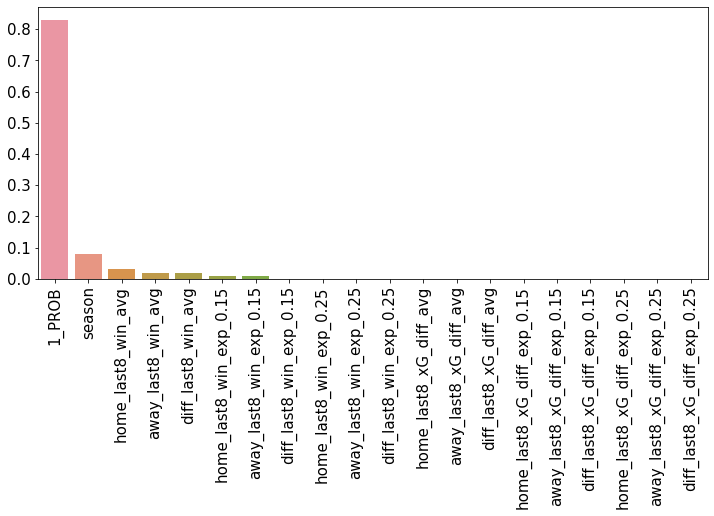

In [103]:
k=top_5_models.iloc[0]['ModelName']
features_tmp = tmp
if 'Last 8' in k:
  features_tmp = new_features_8
elif 'Top 5' in k:
  features_tmp = top_5_features
elif 'Last 5' in k:
  features_tmp = new_features
elif 'cumulative' in k:
  features_tmp = cum_features
print('MODEL '+k)
fig,ax = plt.subplots(1,1,figsize=(12,5))
dict_d={}
for i in range(len(features_tmp)):
  if 'LogisticRegression' in k:
    dict_d[features_tmp[i]] = abs(models['LogisticRegression'].best_estimator_['logr'].coef_[:,i][0])
  else:
    dict_d[features_tmp[i]] = abs(models[k].best_estimator_[models[k].best_estimator_.steps[-1][0]].feature_importances_[i])
dict1 = dict(sorted(dict_d.items(), key=lambda item: item[1],reverse=True))
sns.barplot(x=list(dict1.keys()),y=list(dict1.values()),ax=ax);
ax.set_xticklabels(features_tmp,rotation=90);
plt.show();

MODEL AdaBoostClassifier Last 5 games


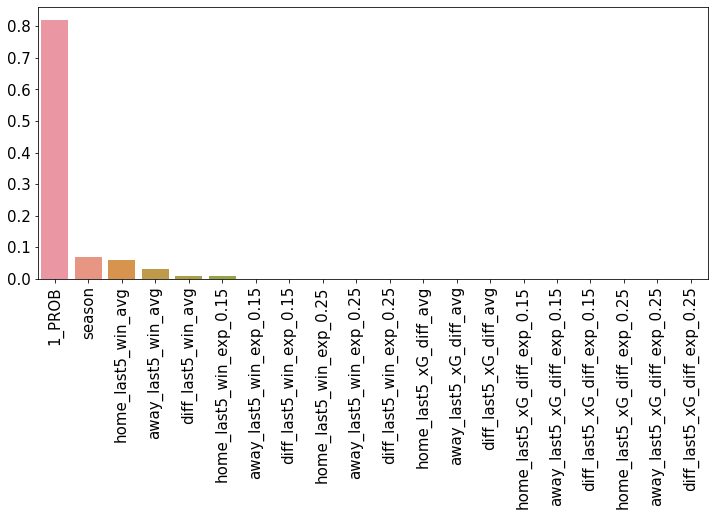

In [104]:
k=top_5_models.iloc[1]['ModelName']
features_tmp = tmp
if 'Last 8' in k:
  features_tmp = new_features_8
elif 'Top 5' in k:
  features_tmp = top_5_features
elif 'Last 5' in k:
  features_tmp = new_features
elif 'cumulative' in k:
  features_tmp = cum_features
print('MODEL '+k)
fig,ax = plt.subplots(1,1,figsize=(12,5))
dict_d={}
for i in range(len(features_tmp)):
  if 'LogisticRegression' in k:
    dict_d[features_tmp[i]] = abs(models['LogisticRegression'].best_estimator_['logr'].coef_[:,i][0])
  else:
    dict_d[features_tmp[i]] = abs(models[k].best_estimator_[models[k].best_estimator_.steps[-1][0]].feature_importances_[i])
dict1 = dict(sorted(dict_d.items(), key=lambda item: item[1],reverse=True))
sns.barplot(x=list(dict1.keys()),y=list(dict1.values()),ax=ax);
ax.set_xticklabels(features_tmp,rotation=90);
plt.show();

MODEL AdaBoostClassifier Top 5 features


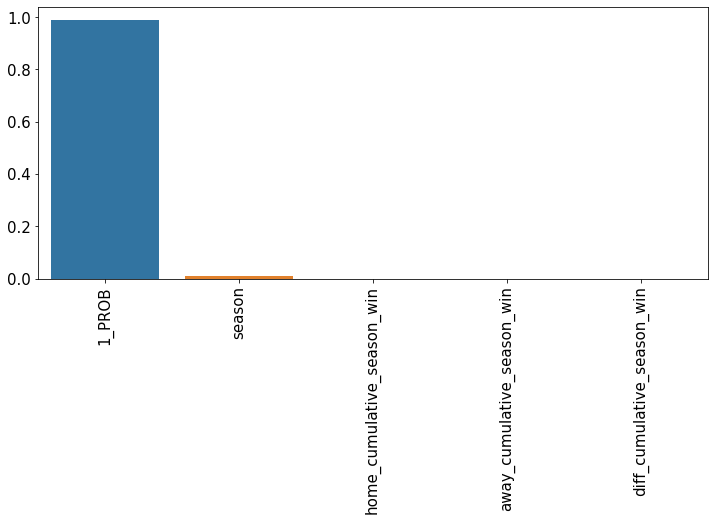

In [105]:
k=top_5_models.iloc[2]['ModelName']
features_tmp = tmp
if 'Last 8' in k:
  features_tmp = new_features_8
elif 'Top 5' in k:
  features_tmp = top_5_features
elif 'Last 5' in k:
  features_tmp = new_features
elif 'cumulative' in k:
  features_tmp = cum_features
print('MODEL '+k)
fig,ax = plt.subplots(1,1,figsize=(12,5))
dict_d={}
for i in range(len(features_tmp)):
  if 'LogisticRegression' in k:
    dict_d[features_tmp[i]] = abs(models['LogisticRegression'].best_estimator_['logr'].coef_[:,i][0])
  else:
    dict_d[features_tmp[i]] = abs(models[k].best_estimator_[models[k].best_estimator_.steps[-1][0]].feature_importances_[i])
dict1 = dict(sorted(dict_d.items(), key=lambda item: item[1],reverse=True))
sns.barplot(x=list(dict1.keys()),y=list(dict1.values()),ax=ax);
ax.set_xticklabels(features_tmp,rotation=90);
plt.show();

MODEL AdaBoostClassifier


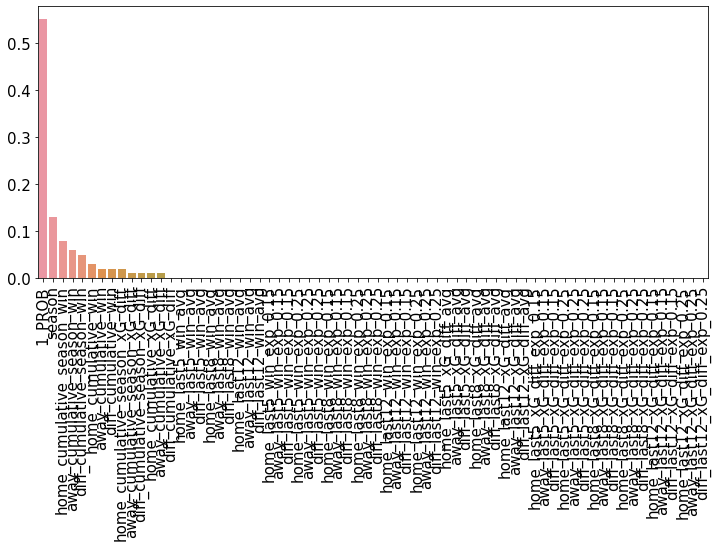

In [106]:
k=top_5_models.iloc[3]['ModelName']
features_tmp = tmp
if 'Last 8' in k:
  features_tmp = new_features_8
elif 'Top 5' in k:
  features_tmp = top_5_features
elif 'Last 5' in k:
  features_tmp = new_features
elif 'cumulative' in k:
  features_tmp = cum_features
print('MODEL '+k)
fig,ax = plt.subplots(1,1,figsize=(12,5))
dict_d={}
for i in range(len(features_tmp)):
  if 'LogisticRegression' in k:
    dict_d[features_tmp[i]] = abs(models['LogisticRegression'].best_estimator_['logr'].coef_[:,i][0])
  else:
    dict_d[features_tmp[i]] = abs(models[k].best_estimator_[models[k].best_estimator_.steps[-1][0]].feature_importances_[i])
dict1 = dict(sorted(dict_d.items(), key=lambda item: item[1],reverse=True))
sns.barplot(x=list(dict1.keys()),y=list(dict1.values()),ax=ax);
ax.set_xticklabels(features_tmp,rotation=90);
plt.show();

MODEL LogisticRegressionWithPCA Top 5 features


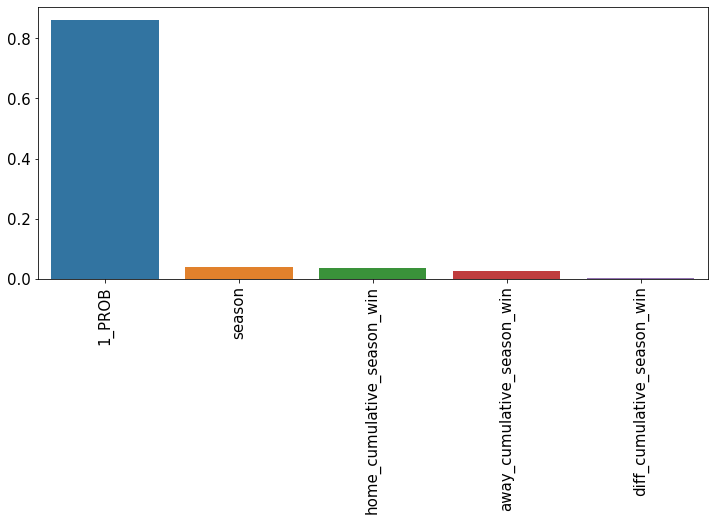

In [107]:
k=top_5_models.iloc[4]['ModelName']
features_tmp = tmp
if 'Last 8' in k:
  features_tmp = new_features_8
elif 'Top 5' in k:
  features_tmp = top_5_features
elif 'Last 5' in k:
  features_tmp = new_features
elif 'cumulative' in k:
  features_tmp = cum_features
print('MODEL '+k)
fig,ax = plt.subplots(1,1,figsize=(12,5))
dict_d={}
for i in range(len(features_tmp)):
  if 'LogisticRegression' in k:
    dict_d[features_tmp[i]] = abs(models['LogisticRegression'].best_estimator_['logr'].coef_[:,i][0])
  else:
    dict_d[features_tmp[i]] = abs(models[k].best_estimator_[models[k].best_estimator_.steps[-1][0]].feature_importances_[i])
dict1 = dict(sorted(dict_d.items(), key=lambda item: item[1],reverse=True))
sns.barplot(x=list(dict1.keys()),y=list(dict1.values()),ax=ax);
ax.set_xticklabels(features_tmp,rotation=90);
plt.show();

**Accuracy% and Profit-Loss% of top 5 models**

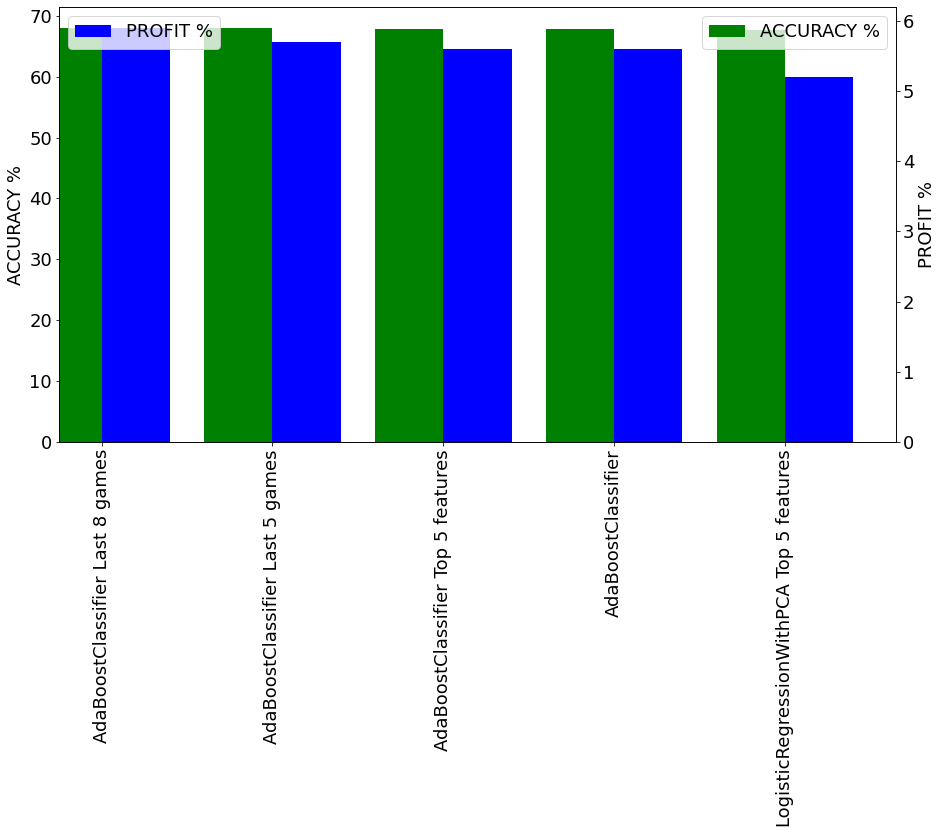

In [108]:
plt.rcParams["font.size"] = 18
fig = plt.figure(figsize=(15,8)) 
ax = fig.add_subplot(111) 
ax2 = ax.twinx() 
width = 0.4
top_5_models.Acc_percentage.plot(kind='bar', color='green', ax=ax, width=width, position=1,label='ACCURACY %')
top_5_models.Profit_Loss_percentage.plot(kind='bar', color='blue', ax=ax2, width=width, position=0, label='PROFIT %')
ax.set_ylabel('ACCURACY %')
ax2.set_ylabel('PROFIT %')
ax.set_xticklabels(top_5_models.ModelName)
ax.legend()
ax2.legend(loc='upper left')
plt.show()

**Top 5 models PR curves**

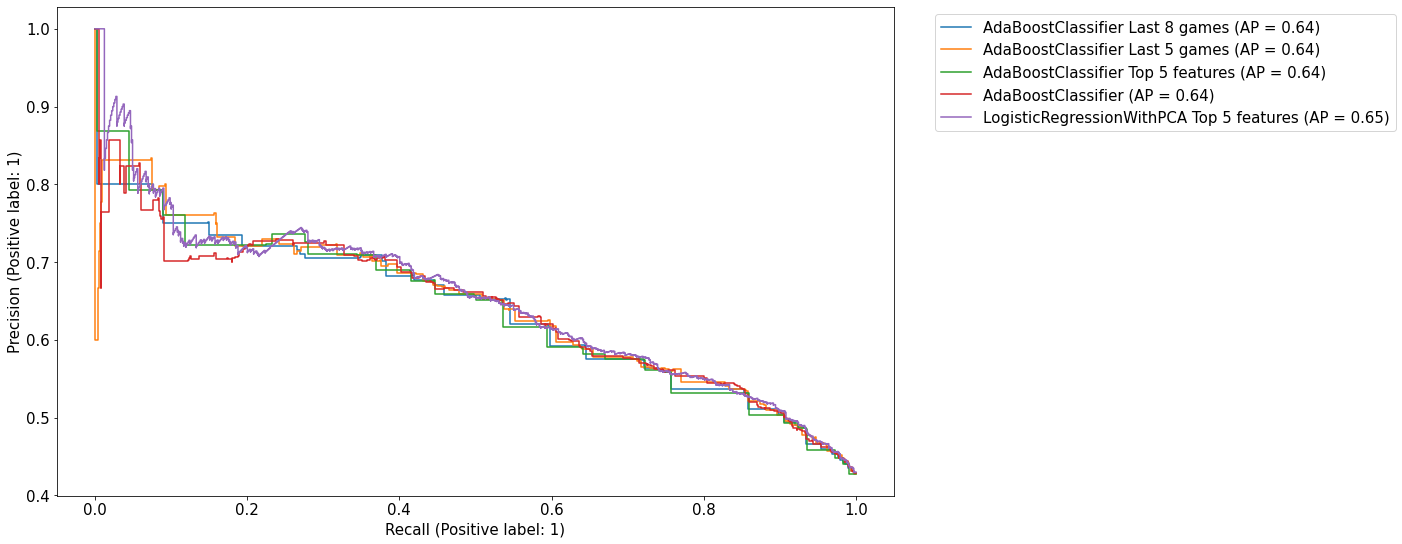

In [110]:
plt.rcParams["font.size"] = 15

fig,ax = plt.subplots(1,1,figsize=(15,9));
for i,r in top_5_models.iterrows():

  list_features = tmp
  if 'Last 8' in r['ModelName']:
    list_features = new_features_8
  elif 'Top 5' in r['ModelName']:
    list_features = top_5_features
  elif 'Last 5' in r['ModelName']:
    list_features = new_features
  elif 'cumulative' in r['ModelName']:
    list_features = cum_features
  if 'NN_' not in r['ModelName']:
    disp = PrecisionRecallDisplay.from_estimator(models[r['ModelName']],test_X[list_features], test_y,name=r['ModelName'],ax=ax);
  else:
    precision1,recall1,thresholds1 = precision_recall_curve(test_y,models[r['ModelName']].predict(test_X[list_features])[:,1])
    disp = PrecisionRecallDisplay(precision=precision1,recall=recall1,pos_label=1);
    disp.plot(ax,label=k);
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


* Even though the area under PR curve is highest for AdaBoost Classifier using features related to last 5 games without PCA and AdaBoost classifier using top 5 featureswithout PCA, we consider **AdaBoost classifier without PCA and trained on the features related to the last 8 games** as the **best model** because of the **high profit** is makes. There is **0.2 to 0.3% increase in profit** in the best model when compared against the above stated models (having same area under PR curves)